# 0 - required packages

In [1]:
# required stuff
import sys
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/thermal')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/aqueous')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/transport')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/rock')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/tables')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/plotting')
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from scipy.interpolate import UnivariateSpline

plt.rcParams['font.family'] = 'Times New Roman'


In [2]:
# import WOW (WOW! Ocean Worlds)
import WOW

# 1 - Run model
## If not running model from scratch, skip to 2

In [3]:
######### define grid ##############

nr = 101       # Number of radii
maxnt = 20000    # Maximum number of time steps

YR = 3.1536E7            #(Year to seconds conversion)
StartTime=3.5*10**6*YR   # Myrs
EndTime = 4567*10**6*YR  # Myrs. Stop time if maxnt is not reached Myr
Radius = 476000          # meters

# parameters for perplex grid
temp_step = 15 # how many degrees temperature difference before recalculating thermal properties? 
press_step= 5 # how many radius points between each perplex equilibration calculation

Ceres = WOW.Planet(nr,StartTime,EndTime,Radius,maxnt,temp_step,press_step)

In [4]:
# Starting temperature
init_Temp = 180
save_result=0

In [5]:
########### initialize comp ############

# Starting composition (Mass fraction of ice and rock must sum to 1)
ICE_frac=0.001
OrgFrac=0.0 # percentage of rock that is organics

# Ice composition
init_IceComp={'H':1/9*100.0,'O':8/9*100}#,'C':0.272,'O':0.728}


# CI, 10% water
init_RockComp={"H":2.919,
               "C":3.194,
               "Mg":8.794,
               "Al":0.780,
               "Si":9.822,
               "S":4.911,
               "Ca":0.845,
               "Fe":16.982,
               "O":51.024,
               "Na":0.458,
               "N":0.271}


# Reweight rock and ice compositions so they sum to 1
sumR=0
for key in init_RockComp:    
    sumR = sumR+init_RockComp[key]
    init_RockComp[key] *= ((1.0-ICE_frac)/100)    
    
sumI=0
for key in init_IceComp:    
    sumI = sumI+init_IceComp[key]
    init_IceComp[key] *= (ICE_frac/100)

# Organic composition
init_orgMass=OrgFrac*sumR
init_orgFrac=OrgFrac

Hwt= 0.65*1
Cwt= 1.0*12.01
Owt= 0.17*16
TotWt=Hwt+Cwt+Owt
Hwt=Hwt/TotWt*OrgFrac
Cwt=Cwt/TotWt*OrgFrac
Owt=Owt/TotWt*OrgFrac

init_orgComp={}
init_orgComp["H"]=Hwt/init_RockComp["H"]
init_orgComp["C"]=Cwt/init_RockComp["C"]
init_orgComp["O"]=Owt/init_RockComp["O"]

mOrg = init_RockComp["H"]*init_orgComp["H"]+init_RockComp["C"]*init_orgComp["C"]+init_RockComp["O"]*init_orgComp["O"]

init_RockComp["H"]=init_RockComp["H"]-init_RockComp["H"]*init_orgComp["H"]
init_RockComp["C"]=init_RockComp["C"]-init_RockComp["C"]*init_orgComp["C"]
init_RockComp["O"]=init_RockComp["O"]-init_RockComp["O"]*init_orgComp["O"]

init_RockComp["IOM"]=0.0


In [6]:
# Element starting wt%
ICE_frac_2=0.0   # change this!
Al_tot_abund=(1-ICE_frac_2)*(1-OrgFrac) * 8370*10**-6*0.9
K_tot_abund= (1-ICE_frac_2)*(1-OrgFrac) * 559*10**-6*1.0
U_tot_abund= (1-ICE_frac_2)*(1-OrgFrac) * 0.00816*10**-6
Th_tot_abund=(1-ICE_frac_2)*(1-OrgFrac) * 0.0298*10**-6

# Radioisotope fractions
Al_26_27_start=5*10**-5
K_40_39_today=0.0119/100
U_235_238_today=0.71/100

# Calc initial radioisotope wt%
Al26start=Al_tot_abund*Al_26_27_start
K40start = WOW.calcOriginAbundance(K_tot_abund*K_40_39_today,"K40")
U235start= WOW.calcOriginAbundance(U_tot_abund*U_235_238_today,"U235")
U238start= WOW.calcOriginAbundance(U_tot_abund*(1-U_235_238_today),"U238")
Th232start=WOW.calcOriginAbundance(Th_tot_abund,"Th232")

# Initial radioisotope abundance
init_Radio={'Al26':Al26start,'K40':K40start,'U235':U235start,'U238':U238start,'Th232':Th232start}

In [7]:
Ceres_Mass=9.38*10**20 #kg
Ceres_Vol = 4.0/3.0*np.pi*Radius**3
Ceres_rho = Ceres_Mass/Ceres_Vol

In [8]:
# Starting properties
init_rho=Ceres_rho
init_K=0.5
init_Cp=1000

# initialize!
Ceres.initialize_comp("ceres",init_IceComp,init_RockComp, init_Radio, init_Temp,init_rho,init_K,init_Cp)

In [9]:
Ceres.runModel()

Step 0 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres91.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104ef7187
#1  0x104ef7d37
#2  0x104ef8613
#3  0x104fe1dc3
#4  0x104fe24d3
#5  0x104fdef53
#6  0x104fe3617
#7  0x104fe46e3
#8  0x104a5d3b3
#9  0x1049d160b
#10  0x10496e963
#11  0x104a5e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6p: No such fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres67.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10482f187
#1  0x10482fd37
#2  0x104830613
#3  0x104919dc3
#4  0x10491a4d3
#5  0x104916f53
#6  0x10491b617
#7  0x10491c6e3
#8  0x1043a93b3
#9  0x10431d60b
#10  0x1042ba963
#11  0x1043aa46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres67.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres67.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres67.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres67.6bb

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres69.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100bf3187
#1  0x100bf3d37
#2  0x100bf4613
#3  0x100cdddc3
#4  0x100cde4d3
#5  0x100cdaf53
#6  0x100cdf617
#7  0x100ce06e3
#8  0x10072d3b3
#9  0x1006a160b
#10  0x10063e963
#11  0x10072e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres69.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres69.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres69.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres69.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres69.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10491f187
#1  0x10491fd37
#2  0x104920613
#3  0x104a09dc3
#4  0x104a0a4d3
#5  0x104a06f53
#6  0x104a0b617
#7  0x104a0c6e3
#8  0x1043cd3b3
#9  0x10434160b
#10  0x1042de963
#11  0x1043ce46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or direc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres90.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres90.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFL

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100ef3187
#1  0x100ef3d37
#2  0x100ef4613
#3  0x100fdddc3
#4  0x100fde4d3
#5  0x100fdaf53
#6  0x100fdf617
#7  0x100fe06e3
#8  0x100a093b3
#9  0x10097d60b
#10  0x10091a963
#11  0x100a0a46f
mv: /Users/samuelc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1045cb187
#1  0x1045cbd37
#2  0x1045cc613
#3  0x1046b5dc3
#4  0x1046b64d3
#5  0x1046b2f53
#6  0x1046b7617
#7  0x1046b86e3
#8  0x1041853b3
#9  0x1040f960b
#10  0x104096963
#11  0x10418646f
mv: /Users/samuelc

Step 1000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10282b187
#1  0x10282bd37
#2  0x10282c613
#3  0x102915dc3
#4  0x1029164d3
#5  0x102912f53
#6  0x102917617
#7  0x1029186e3
#8  0x1023893b3
#9  0x1022fd60b
#10  0x10229a963
#11  0x10238a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102a0b187
#1  0x102a0bd37
#2  0x102a0c613
#3  0x102af5dc3
#4  0x102af64d3
#5  0x102af2f53
#6  0x102af7617
#7  0x102af86e3
#8  0x1025113b3
#9  0x10248560b
#10  0x102422963
#11  0x10251246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres77.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10326f187
#1  0x10326fd37
#2  0x103270613
#3  0x103359dc3
#4  0x10335a4d3
#5  0x103356f53
#6  0x10335b617
#7  0x10335c6e3
#8  0x102dd93b3
#9  0x102d4d60b
#10  0x102cea963
#11  0x102dda46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres77.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres77.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres77.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres77.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres77.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104943187
#1  0x104943d37
#2  0x104944613
#3  0x104a2ddc3
#4  0x104a2e4d3
#5  0x104a2af53
#6  0x104a2f617
#7  0x104a306e3
#8  0x1044cd3b3
#9  0x10444160b
#10  0x1043de963
#11  0x1044ce46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6tx: No such file or directory
mv: /U

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres89.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x103493187
#1  0x103493d37
#2  0x103494613
#3  0x10357ddc3
#4  0x10357e4d3
#5  0x10357af53
#6  0x10357f617
#7  0x1035806e3
#8  0x102ee13b3
#9  0x102e5560b
#10  0x102df2963
#11  0x102ee246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres89.6tx: No such file or directory
mv: /U

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102d53187
#1  0x102d53d37
#2  0x102d54613
#3  0x102e3ddc3
#4  0x102e3e4d3
#5  0x102e3af53
#6  0x102e3f617
#7  0x102e406e3
#8  0x1028613b3
#9  0x1027d560b
#10  0x102772963
#11  0x10286246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or direc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 2000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1048ef187
#1  0x1048efd37
#2  0x1048f0613
#3  0x1049d9dc3
#4  0x1049da4d3
#5  0x1049d6f53
#6  0x1049db617
#7  0x1049dc6e3
#8  0x1043793b3
#9  0x1042ed60b
#10  0x10428a963
#11  0x10437a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres80.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100fa7187
#1  0x100fa7d37
#2  0x100fa8613
#3  0x101091dc3
#4  0x1010924d3
#5  0x10108ef53
#6  0x101093617
#7  0x1010946e3
#8  0x100b253b3
#9  0x100a9960b
#10  0x100a36963
#11  0x100b2646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres80.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100fd7187
#1  0x100fd7d37
#2  0x100fd8613
#3  0x1010c1dc3
#4  0x1010c24d3
#5  0x1010bef53
#6  0x1010c3617
#7  0x1010c46e3
#8  0x100b2d3b3
#9  0x100aa160b
#10  0x100a3e963
#11  0x100b2e46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10328b187
#1  0x10328bd37
#2  0x10328c613
#3  0x103375dc3
#4  0x1033764d3
#5  0x103372f53
#6  0x103377617
#7  0x1033786e3
#8

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres81.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100a37187
#1  0x100a37d37
#2  0x100a38613
#3  0x100b21dc3
#4  0x100b224d3
#5  0x100b1ef53
#6  0x100b23617
#7  0x100b246e3
#8  0x1005013b3
#9  0x10047560b
#10  0x100412963
#11  0x10050246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres81.6p: No such fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x105333187
#1  0x105333d37
#2  0x105334613
#3  0x10541ddc3
#4  0x10541e4d3
#5  0x10541af53
#6  0x10541f617
#7  0x1054206e3
#8  0x104e593b3
#9  0x104dcd60b
#10  0x104d6a963
#11  0x104e5a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres65.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10324f187
#1  0x10324fd37
#2  0x103250613
#3  0x103339dc3
#4  0x10333a4d3
#5  0x103336f53
#6  0x10333b617
#7  0x10333c6e3
#8  0x102dad3b3
#9  0x102d2160b
#10  0x102cbe963
#11  0x102dae46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6p: No such fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 3000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres73.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104a97187
#1  0x104a97d37
#2  0x104a98613
#3  0x104b81dc3
#4  0x104b824d3
#5  0x104b7ef53
#6  0x104b83617
#7  0x104b846e3
#8  0x1045413b3
#9  0x1044b560b
#10  0x104452963
#11  0x10454246f
mv: /Users/samuelc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres73.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10260f187
#1  0x10260fd37
#2  0x102610613
#3  0x1026f9dc3
#4  0x1026fa4d3
#5  0x1026f6f53
#6  0x1026fb617
#7  0x1026fc6e3
#8  0x1021ad3b3
#9  0x10212160b
#10  0x1020be963
#11  0x1021ae46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres73.6tx: No such file or directory
mv: /U

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres65.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102f7b187
#1  0x102f7bd37
#2  0x102f7c613
#3  0x103065dc3
#4  0x1030664d3
#5  0x103062f53
#6  0x103067617
#7  0x1030686e3
#8  0x102a893b3
#9  0x1029fd60b
#10  0x10299a963
#11  0x102a8a46f
mv: /Users/samuelc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres69.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10551f187
#1  0x10551fd37
#2  0x105520613


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres90.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1047c7187
#1  0x1047c7d37
#2  0x1047c8613
#3  0x1048b1dc3
#4  0x1048b24d3
#5  0x1048aef53
#6  0x1048b3617
#7  0x1048b46e3
#8

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres71.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10143b187
#1  0x10143bd37
#2  0x10143c613
#3  0x101525dc3
#4  0x1015264d3
#5  0x101522f53
#6  0x101527617
#7  0x1015286e3
#8  0x100fa93b3
#9  0x100f1d60b
#10  0x100eba963
#11  0x100faa46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres71.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres71.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres71.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres71.6bb

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres90.6ib')
Fortran runtime error: End of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 4000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100fd7187
#1  0x100fd7d37
#2  0x100fd8613
#3  0x1010c1dc3
#4  0x1010c24d3
#5  0x1010bef53
#6  0x1010c3617
#7  0x1010c46e3
#8  0x100bbd3b3
#9  0x100b3160b
#10  0x100ace963
#11  0x100bbe46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres73.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102c37187
#1  0x102c37d37
#2  0x102c38613
#3  0x102d21dc3
#4  0x102d224d3
#5  0x102d1ef53
#6  0x102d23617
#7  0x102d246e3
#8  0x1026f53b3
#9  0x10266960b
#10  0x102606963
#11  0x1026f646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres73.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres73.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres73.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres73.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres73.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres66.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100a07187
#1  0x100a07d37
#2  0x100a08613
#3  0x100af1dc3
#4  0x100af24d3
#5  0x100aeef53
#6  0x100af3617
#7  0x100af46e3
#8  0x1005553b3
#9  0x1004c960b
#10  0x100466963
#11  0x10055646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres66.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 5000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres71.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres71.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres71.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: I

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres77.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1049bb187
#1  0x1049bbd37
#2  0x1049bc613
#3  0x104aa5dc3
#4  0x104aa64d3
#5  0x104aa2f53
#6  0x104aa7617
#7  0x104aa86e3
#8  0x1045753b3
#9  0x1044e960b
#10  0x104486963
#11  0x10457646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres77.6tx: No such file or directory
mv: /U

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 6000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres76.6ib')
Fortran runtime error: End of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 7000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Step 8000 out of 20000
Step 9000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres89.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100dd7187
#1  0x100dd7d37
#2  0x100dd8613
#3  0x100ec1dc3
#4  0x100ec24d3
#5  0x100ebef53
#6  0x100ec3617
#7  0x100ec46e3
#8  0x1009053b3
#9  0x10087960b
#10  0x100816963
#11  0x10090646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres89.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres89.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres89.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres89.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres89.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Step 10000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x103093187
#1  0x103093d37
#2  0x103094613
#3  0x10317ddc3
#4  0x10317e4d3
#5  0x10317af53
#6  0x10317f617
#7  0x1031806e3
#8  0x102c413b3
#9  0x102bb560b
#10  0x102b52963
#11  0x102c4246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10481f187
#1  0x10481fd37
#2  0x104820613
#3  0x104909dc3
#4  0x10490a4d3
#5  0x104906f53
#6  0x10490b617
#7  0x10490c6e3
#8  0x1043353b3
#9  0x1042a960b
#10  0x104246963
#11  0x10433646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6p: No such fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres92.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: I

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres92.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10093b187
#1  0x10093bd37
#2  0x10093c613
#3  0x100a25dc3
#4  0x100a264d3
#5  0x100a22f53
#6  0x100a27617
#7  0x100a286e3
#8

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 11000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres72.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100af3187
#1  0x100af3d37
#2  0x100af4613
#3  0x100bdddc3
#4  0x100bde4d3
#5  0x100bdaf53
#6  0x100bdf617
#7  0x100be06e3
#8  0x1006c13b3
#9  0x10063560b
#10  0x1005d2963
#11  0x1006c246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres72.6tx: No such file or directory
mv: /U

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres88.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x101183187
#1  0x101183d37
#2  0x101184613
#3  0x10126ddc3
#4  0x10126e4d3
#5  0x10126af53
#6  0x10126f617
#7  0x1012706e3
#8  0x100d153b3
#9  0x100c8960b
#10  0x100c26963
#11  0x100d1646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres88.6t: No such file or direc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres79.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1026c3187
#1  0x1026c3d37
#2  0x1026c4613
#3  0x1027addc3
#4  0x1027ae4d3
#5  0x1027aaf53
#6  0x1027af617
#7  0x1027b06e3
#8  0x1022453b3
#9  0x1021b960b
#10  0x102156963
#11  0x10224646f
mv: /Users/samuelc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 12000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x1013f7187
#1  0x1013f7d37
#2  0x1013f8613
#3  0x1014e1dc3
#4  0x1014e24d3
#5  0x1014def53
#6  0x1014e3617
#7  0x1014e46e3
#8  0x100f853b3
#9  0x100ef960b
#10  0x100e96963
#11  0x100f8646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres91.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x100a27187
#1  0x100a27d37
#2  0x100a28613
#3  0x100b11dc3
#4  0x100b124d3
#5  0x100b0ef53
#6  0x100b13617
#7  0x100b146e3
#8  0x1005553b3
#9  0x1004c960b
#10  0x100466963
#11  0x10055646f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres91.6ba: No such file or directory
Note: The following floating-point excepti

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres83.6ib')
Fortran runtime error: End of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres87.6ib')
Fortran runtime error: End of fi

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 13000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

no place to put impurities found. Crash imminent
{'H': -21399022830732.625, 'C': 8950185325987.562, 'Mg': 0.0, 'Al': 0.0, 'Si': 0.0, 'S': 104941255689.18828, 'Ca': 0.0, 'Fe': 0.0, 'O': -220489000002916.0, 'Na': 0.0, 'N': 232832896252994.72}


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres90.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x102f07187
#1  0x102f07d37
#2  0x102f08613
#3  0x102ff1dc3
#4  0x102ff24d3
#5  0x102feef53
#6  0x102ff3617
#7  0x102ff46e3
#8  0x102a693b3
#9  0x1029dd60b
#10  0x10297a963
#11  0x102a6a46f
mv: /Users/samuelc

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres75.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10277f187
#1  0x10277fd37
#2  0x102780613
#3  0x102869dc3
#4  0x10286a4d3
#5  0x102866f53
#6  0x10286b617
#7  0x10286c6e3
#8  0x1022e13b3
#9  0x10225560b
#10  0x1021f2963
#11  0x1022e246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6bb

Extreme heat capacity value in update properties. Resetting


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 14000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 15000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6ba: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres86.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104bbb187
#1  0x104bbbd37
#2  0x104bbc613
#3  0x104ca5dc3
#4  0x104ca64d3
#5  0x104ca2f53
#6  0x104ca7617
#7  0x104ca86e3
#8  0x1046fd3b3
#9  0x10467160b
#10  0x10460e963
#11  0x1046fe46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres86.6tx: No such file or dire

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 16000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres75.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x10141b187
#1  0x10141bd37
#2  0x10141c613
#3  0x101505dc3
#4  0x1015064d3
#5  0x101502f53
#6  0x101507617
#7  0x1015086e3
#8  0x100fed3b3
#9  0x100f6160b
#10  0x100efe963
#11  0x100fee46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres75.6tx: No such file or directory
mv: /U

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres85.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x105413187
#1  0x105413d37
#2  0x105414613
#3  0x1054fddc3
#4  0x1054fe4d3
#5  0x1054faf53
#6  0x1054ff617
#7  0x1055006e3
#8  0x104f993b3
#9  0x104f0d60b
#10  0x104eaa963
#11  0x104f9a46f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres85.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Step 17000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of file src/rdd2lh.f (unit = 37, file = 'ceres70.6ib')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x104d9b187
#1  0x104d9bd37
#2  0x104d9c613
#3  0x104e85dc3
#4  0x104e864d3
#5  0x104e82f53
#6  0x104e87617
#7  0x104e886e3
#8  0x1049313b3
#9  0x1048a560b
#10  0x104842963
#11  0x10493246f
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6tx: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6t: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6p: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ceres70.6bb: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 18000 out of 20000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
At line 72 of fi

In [10]:
if save_result==1:
    with open('ceres5.pkl', 'wb') as file:
        pickle.dump(Ceres, file)

# 2 - Load previously run model

In [9]:
### Load with this code    
    
with open('ceres5.pkl', 'rb') as file:
    Ceres = pickle.load(file)

In [10]:
Ceres.nt= 18324 #This is when the model stopped

stime=Ceres.times[0]/3.154e+7/1e6
etime=3.3e3 # This sets the last time to plot

In [11]:
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

# 3 - Plot outputs

## Figure 1

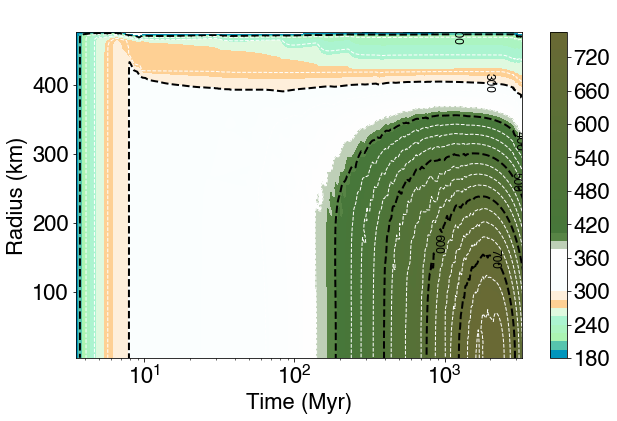

In [12]:
ax = Ceres.plotTemp("Temp"," ")
plt.xscale("log")
plt.xlim([stime,etime])
plt.savefig('Fig1_temperature.pdf')  

## Figure 2a

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/2831606028.py:97: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j] = pP[i][j] / sumM[j]


0.4168259623385439


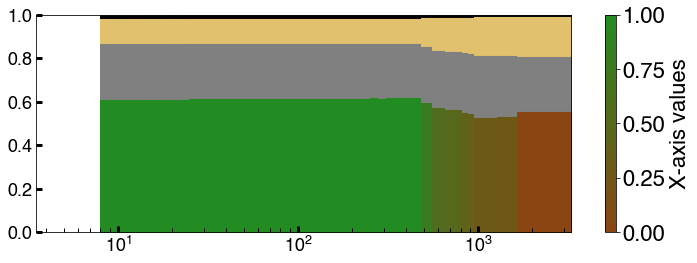

In [13]:
def plotHydration(self,radius):
    pP = dict()
    pP
    Htot=np.zeros(self.nt)
    Htot2=np.zeros(self.nt)
    tt=np.zeros(self.nt)
    
    
    lab_dict = {"IOM": "IOM",
                "IOMp": "IOM pyrolysates",
                "other": "minor phases",
                "gph": "Graphite",
                "q": "Quartz",
                "Opx": "Silicates",
                "Cpx": "Silicates",
                "acm": "Silicates",
                "pyr": "Iron sulfides",
                "Po": "Iron sulfides",
                "tro": "Iron sulfides",
                "lot": "Iron sulfides",
                "trov": "Iron sulfides",
                "Amph": "Silicates",
                "Chl": "Silicates",
                "Tlc": "Silicates",
                "Pu": "Silicates",
                "Do": "Carbonates",
                "Cc": "Carbonates",
                "cc": "Carbonates",
                "dol": "Carbonates",
                "arag": "Carbonates",
                "Pl": "Silicates",
                "ab": "Silicates",
                "hem": "Iron oxides",
                "gth": "Iron oxides",
                "Ol": "Silicates",
                "Sp": "Iron oxides",
                "Atg": "Silicates",
                "glt": "Silicates",
                "cen": "Silicates",
                "ne": "Silicates",
                "pren": "Silicates",
                "en": "Silicates",
                "liz": "Silicates",
                "any": "Sulfates",
                "naph": "Silicates",
                "cor": "Iron oxides", # actually Al oxide
                "Mag": "Carbonates",
                "Gt": "Iron oxides", # actually Al oxide
                "iron": "Iron",
                "mt": "Iron oxides"}

    col_dict = {"IOM": "#964B00",
                "IOM pyrolysates": "#5C4033",
                "minor phases": 'skyblue',
                "Graphite": "#000000",
                "Quartz": "#FFFFFF",
                "Carbonates": "#808080",
                "Anhydrous silicates": "#9ab973",
                "Iron sulfides": "#E1C16E",
                "Hydrous silicates": "#033220",
                "Iron oxides":"#5C4033",
                "Al oxides": "#9A2A2A",
                "Sulfates": "#b0c4de",
                "Iron": "#A9A9A9"}    
    
    for j in range(self.nt):
        tt[j]=self.grid[j][radius].Temp
        phases = self.grid[j][radius].RockPhases
        for i in range(len(phases)):
            if "_rs" in phases[i]:
                phases[i] = phases[i].replace('_rs', '')
            if "_1" in phases[i]:
                phases[i] = phases[i].replace('_1', '')
            if phases[i]=="Bulk":
                Htot[j]+=self.grid[j][radius].RockPhaseDat[i]['H']/100*self.grid[j][radius].RockPhaseDat[i]["wt%"]/100
            else:
                Htot2[j]+=self.grid[j][radius].RockPhaseDat[i]['H']/100*self.grid[j][radius].RockPhaseDat[i]["wt%"]/100
        for i in range(0, len(phases)):
                if not phases[i] == "Bulk":
                    labT = "other"
                    if phases[i] not in lab_dict:
                        print(phases[i])
                    if phases[i] in lab_dict:
                        labT = lab_dict[phases[i]]
                    if labT in pP:
                        pP[labT][j] += self.grid[j][radius].RockPhaseDat[i]["wt%"]
                    else:
                        pP[labT] = np.zeros(self.nt)
                        pP[labT][j] = self.grid[j][radius].RockPhaseDat[i]["wt%"]
                        
    sumM = np.zeros(self.nt)
    for j in range(self.nt):
        for i in pP:
            sumM[j] += pP[i][j]
    for j in range(self.nt):
        for i in pP:
            pP[i][j] = pP[i][j] / sumM[j]
            
            
    YR=3.1536E7
    time=self.times / YR / 10 ** 6
    
            
    print(Htot2[-1]/np.max(Htot2))
    Htot2[0:1000]=np.max(Htot2)
    Htot2=((Htot2-np.min(Htot2))/(np.max(Htot2)-np.min(Htot2)))
                
    # Generate colors based on the x values using a colormap
    norm = plt.Normalize(Htot2.min(), Htot2.max())
    colors = ['saddlebrown','forestgreen']
    custom_cmap = LinearSegmentedColormap.from_list('forest_brown', colors)
    cmap = plt.cm.gist_earth  # You can choose any colormap here
    colors = custom_cmap(Htot2/np.max(Htot2))
    

    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))

    # Stackplot allows for static colors, but to make the colors change over x, we need to plot manually
    for i in range(len(Htot2) - 1):
        ax.fill_between(time[i:i+2], pP["Silicates"][i:i+1], color=colors[i])  # Dynamic color for y2
        # Stack the remaining layers with fixed colors
        bottom = pP["Silicates"][i:i+1]
        for j in pP.keys():
            if not j=="Silicates":
                ax.fill_between(time[i:i+2], bottom + pP[j][i:i+1], bottom, color=col_dict[j])
                bottom += pP[j][i:i+1]
    plt.ylim([0, 1])
    plt.xlim([stime,etime])
    plt.xscale("log")
    plt.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
    plt.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  
    
    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])  # Needed for colorbar to work
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('X-axis values')  # Label for colorbar
    plt.savefig('Fig2a.pdf')
    
    
    
    
    
plotHydration(Ceres,0)

## Figure 2b

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/2192063868.py:41: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))


Optimized parameters: L = 6727677585351323648.00, x0 = 789.50, k = 0.01


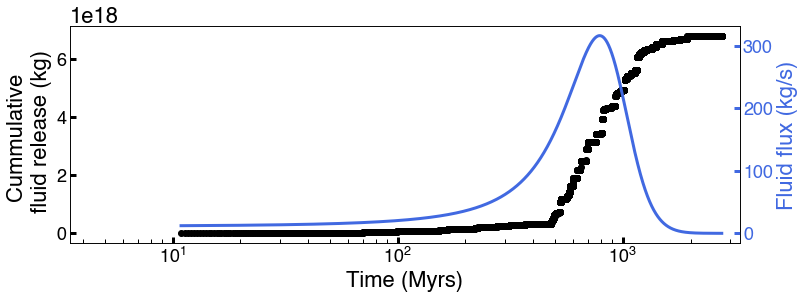

In [15]:
mEl=dict()
for j in ["C","H","O","N","S"]:
    Car=np.zeros(maxnt)
    hydroM=np.zeros(maxnt)
    for i in range(0,maxnt):
        for k in range(0,Ceres.nr):
            if j in Ceres.grid[i,k].AqComp:
                Car[i]+=Ceres.grid[i,k].AqComp[j]
            if j in Ceres.grid[i,k].IceComp:
                Car[i]+=Ceres.grid[i,k].IceComp[j]
            if i>50 and j=="N":
                Car[i]=0
    mEl[j]=Car

s_index=1683
e_index=11000

si2=25
si3=51
ei2=50
ei3=1682

totM_vol=0

for i in mEl:
    totM_vol+=mEl[i]
    
totM_vol_diff=totM_vol

x_data_2 = Ceres.times[si2:ei2]/3.154e+7/1e6
x_data_3 = Ceres.times[si3:ei3]/3.154e+7/1e6
y_data_2 = totM_vol_diff[si2:ei2]-totM_vol_diff[si2]
y_data_3 = totM_vol_diff[si3:ei3]-totM_vol_diff[si3]

# Define the sigmoid function
def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))


x_data = Ceres.times[si2:e_index-2]/3.154e+7/1e6
y_data_1 = totM_vol_diff[s_index:e_index]-totM_vol_diff[s_index]+y_data_3[-1]
y_data=np.append(y_data_2,np.append(y_data_3,y_data_1))


# Use curve_fit to fit the sigmoid function to the data
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0=[max(y_data), np.median(x_data), 1])

# popt contains the optimized parameters L, x0, k
L, x0, k = popt

# Print the optimized parameters
print(f"Optimized parameters: L = {L:.2f}, x0 = {x0:.2f}, k = {k:.2f}")


fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

ax1.set_xlabel('Time (Myrs)')
ax1.set_xscale('log')
ax1.set_xlim([stime,etime])
ax1.set_ylabel('Cummulative \n fluid release (kg)', color='k')
ax2.set_ylabel('Fluid flux (kg/s)', color='royalblue')



# Plot the data and the fitted curve
ax1.scatter(x_data, y_data, label='Data', color='k')
ax2.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
ax2.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)
ax1.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
ax1.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1) 

kg_per_myr=np.diff(sigmoid(x_data, *popt))/np.diff(x_data)
kg_per_s=kg_per_myr/1e6/3.154e+7
ax2.plot(x_data[0:-1],kg_per_s,color='royalblue',linewidth=3)
ax2.tick_params(axis='y', colors='royalblue')



plt.savefig('Fig2b.pdf')


## Figure 2c

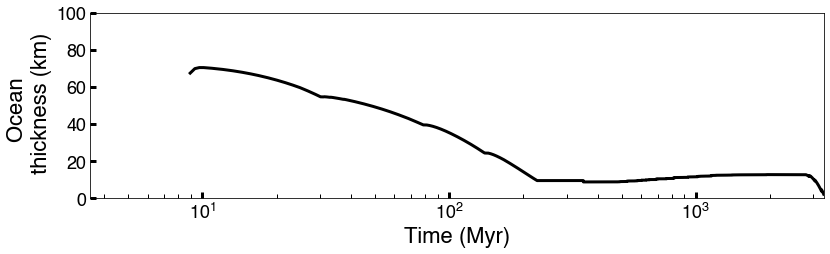

In [16]:
bottom=np.zeros(Ceres.nt)
top=np.zeros(Ceres.nt)
aQMass=np.zeros(Ceres.nt)
aQMass2=np.zeros(Ceres.nt)
aQMass3=np.zeros(Ceres.nt)
toptop=np.zeros(Ceres.nt)

for i in range(0,Ceres.nt):
    for j in range(0,nr-1):
        aQMass2[i]+=Ceres.grid[i,j].getAqMass()
    for j in range(92,nr-1):
        aQMass3[i]+=Ceres.grid[i,j].getAqMass()

    
    botInd=nr
    toptop[i]=Ceres.grid[i,-1].Top
    for j in range(0,nr):
        if Ceres.grid[i,j].Celltype==2:
            bottom[i]=Ceres.grid[i,j].Bot
            botInd=j
            break
    for j in range(botInd-1,nr):
            aQMass[i]+=Ceres.grid[i,j].getAqMass()
    for j in range(0,nr):
        if Ceres.grid[i,nr-j-1].Celltype==2:
            top[i]=Ceres.grid[i,nr-j-1].Top
            break

thicknessR=top-bottom


RRR=4*np.pi*(400*1000)**2
Voc=aQMass3/1000
Doc=Voc/RRR

plt.figure(figsize=(12, 4))
plt.plot(Ceres.times[20:-1]/3.154e+7/1e6,(Doc[20:-1]/1000-10)*1.2,'k',linewidth=3) # offset ocean thickness to account for ocean/seafloor interface cell
plt.xlim([stime,etime])
plt.ylim([0,100])
plt.xlabel("Time (Myr)")
plt.ylabel("Ocean \n thickness (km)")
plt.xscale('log')
plt.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
plt.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  
plt.tight_layout()
plt.savefig('Fig2c.pdf',bbox_inches='tight')

## Figure 2d

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3597421704.py:23: RuntimeWarning: divide by zero encountered in log10
  ind_good=-np.log10(H)>8
/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3597421704.py:40: RuntimeWarning: divide by zero encountered in log10
  ind_good=-np.log10(H)>8
/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3597421704.py:42: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(Ceres.times[ind_good]/3.154e+7/1e6,-np.log10(H[ind_good]),'k',linewidth=3)
/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3597421704.py:43: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(Ceres.times[ind_good]/3.154e+7/1e6,-np.log10(H[ind_good]),'k',label="pH",linewidth=3)


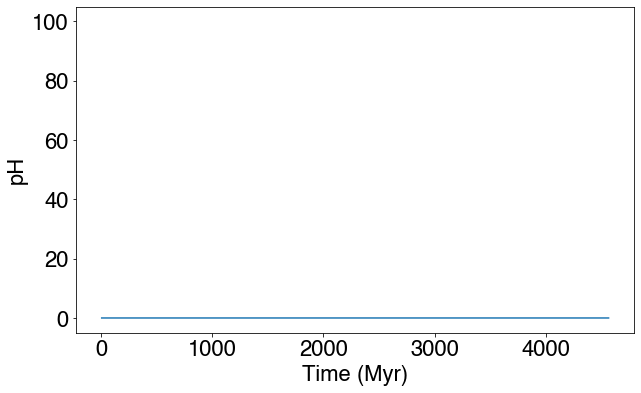

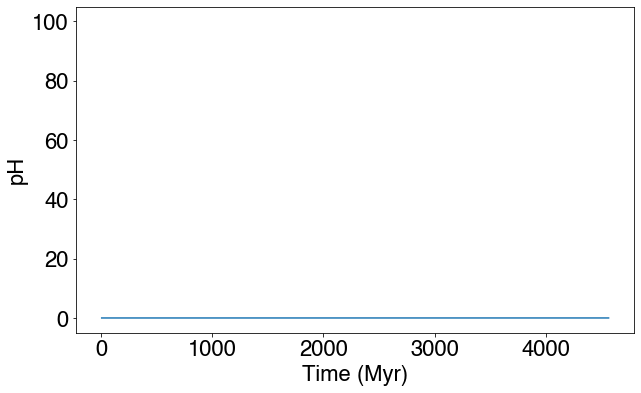

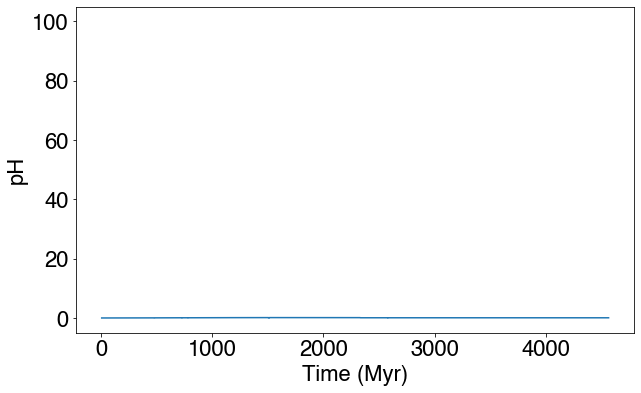

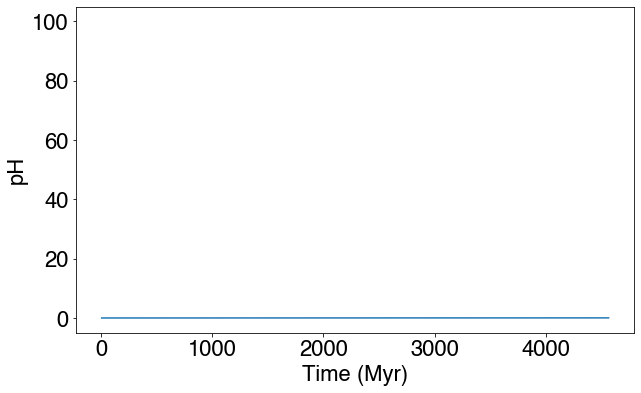

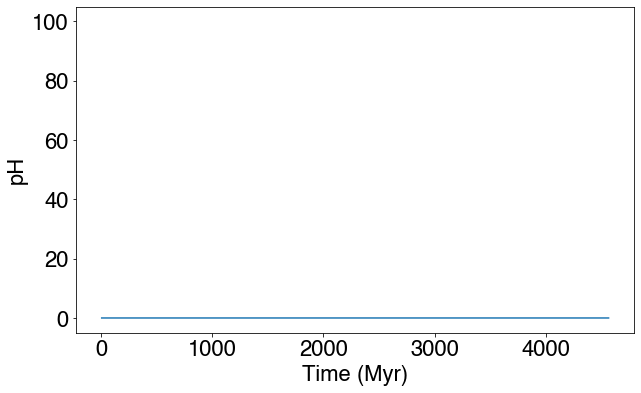

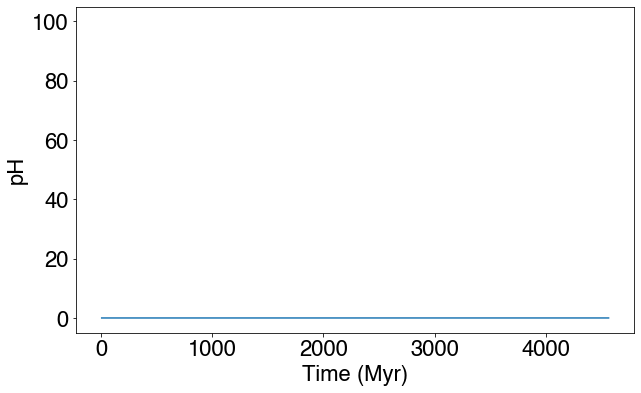

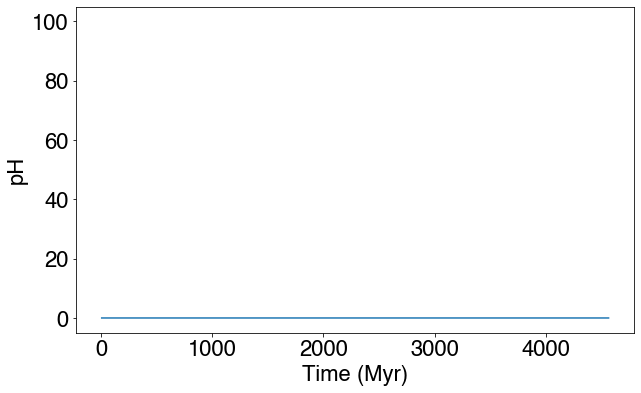

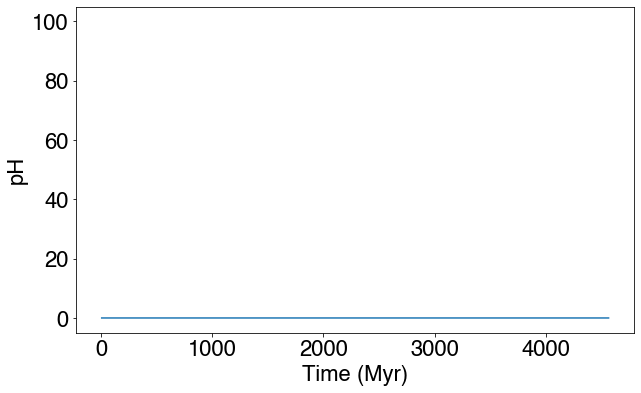

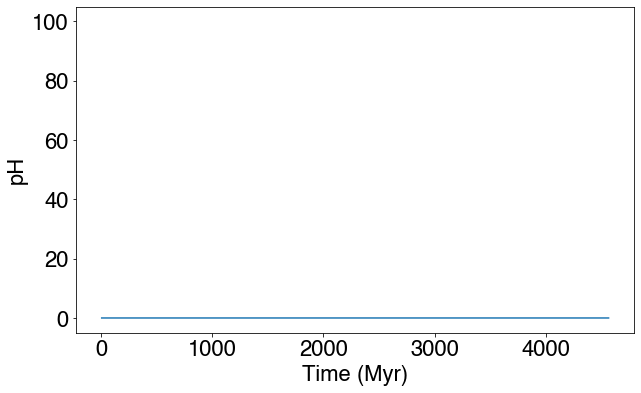

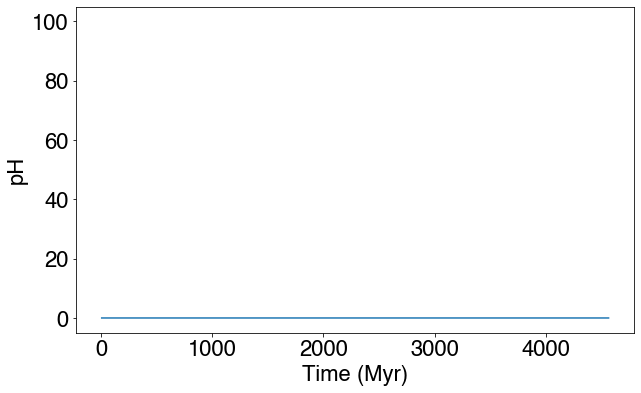

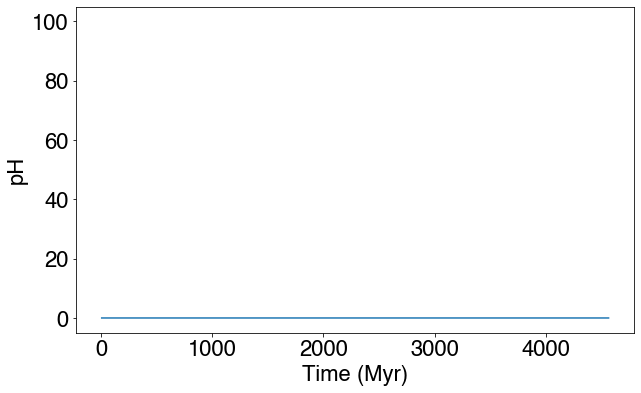

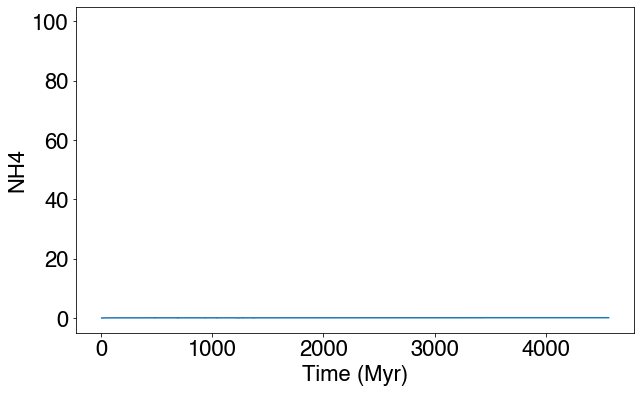

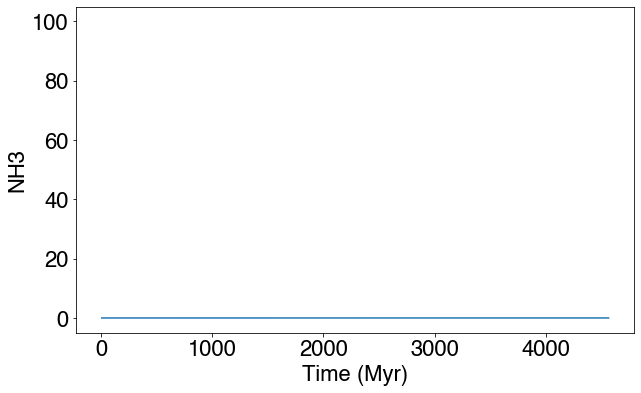

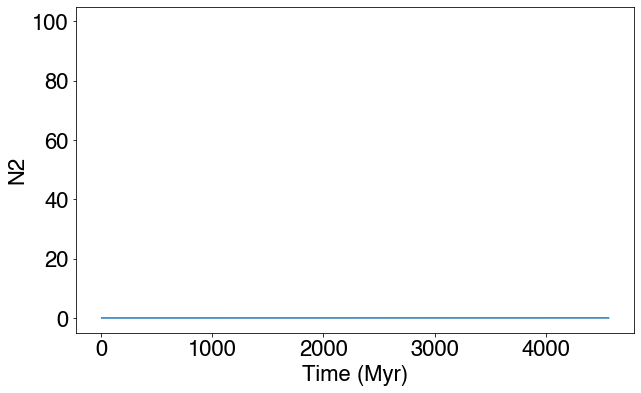

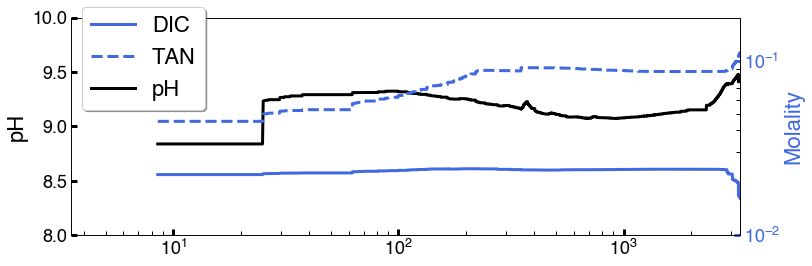

In [18]:
indD=68
indS=93

f,CO3_d=Ceres.plotDictAttributeLine("AqSpec","CO3--","pH",indD,1)
f,HCO3_d=Ceres.plotDictAttributeLine("AqSpec","HCO3-","pH",indD,1)
f,CO2_d=Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","pH",indD,1)
f,CH4_d=Ceres.plotDictAttributeLine("AqSpec","Methane(aq)","pH",indD,1)
f,CO3=Ceres.plotDictAttributeLine("AqSpec","CO3--","pH",indS,1)
f,HCO3=Ceres.plotDictAttributeLine("AqSpec","HCO3-","pH",indS,1)
f,CO2=Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","pH",indS,1)
f,CH4=Ceres.plotDictAttributeLine("AqSpec","Methane(aq)","pH",indS,1)
f,H2_d=Ceres.plotDictAttributeLine("AqSpec","H2(aq)","pH",indD,1)
f,H2=Ceres.plotDictAttributeLine("AqSpec","H2(aq)","pH",indS,1)
f,H=Ceres.plotDictAttributeLine("AqSpec","H+","pH",93,1)
f,NH4=Ceres.plotDictAttributeLine("AqSpec","NH4+","NH4",93,1)
f,NH3=Ceres.plotDictAttributeLine("AqSpec","NH3(aq)","NH3",93,1)
f,N2=Ceres.plotDictAttributeLine("AqSpec","N2(aq)","N2",93,1)

H[22:55]=H[55]

ind_good=-np.log10(H)>8

ind_good=CH4>1e-6
ind_good_2=NH4>1e-6

fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax2.plot(Ceres.times[ind_good]/3.154e+7/1e6,CO3[ind_good]+HCO3[ind_good]+CO2[ind_good],'royalblue',label=r"DIC",linewidth=3)
ax2.plot(Ceres.times[ind_good_2]/3.154e+7/1e6,NH3[ind_good_2]+NH4[ind_good_2]+N2[ind_good_2],'--',color='royalblue',label=r"TAN",linewidth=3)
ax2.set_ylim([10**-2,10**-0.75])
plt.xlim([stime,etime])
plt.xlabel("Time (Myr)")
ax2.set_ylabel("Molality",color='royalblue')
ax2.set_yscale('log')
plt.xscale('log')


ind_good=-np.log10(H)>8

ax1.plot(Ceres.times[ind_good]/3.154e+7/1e6,-np.log10(H[ind_good]),'k',linewidth=3)
ax2.plot(Ceres.times[ind_good]/3.154e+7/1e6,-np.log10(H[ind_good]),'k',label="pH",linewidth=3)
ax1.set_ylim([8,10])
ax1.set_ylabel("pH",color='k')
ax1.tick_params(axis='y', colors='k')
ax2.tick_params(axis='y', colors='royalblue')

ax2.legend(bbox_to_anchor=(0, 1.1), loc='upper left',
               ncol=1, fancybox=True, shadow=True)

ax1.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
ax1.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  
ax2.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
ax2.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  

plt.savefig('Fig2d.pdf')

## Figure 4a

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/1107297397.py:48: RuntimeWarning: invalid value encountered in true_divide
  tau=-Mco2[ib:ie]/dmdt/(1e6)
/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/1107297397.py:89: RuntimeWarning: invalid value encountered in true_divide
  tau=-Mco2[ib:ie]/dmdt/(1e6)


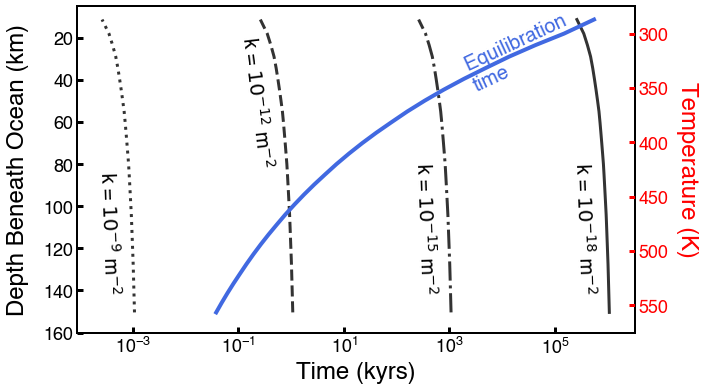

In [22]:
depth_k8 = np.zeros(Ceres.nt)
depth_k12= np.zeros(Ceres.nt)
depth_k16= np.zeros(Ceres.nt)
depthInd_k8 = np.zeros(Ceres.nt)
depthInd_k12= np.zeros(Ceres.nt)
depthInd_k16= np.zeros(Ceres.nt)

for x in range(0,Ceres.nt):
    noEquilTime = 0
    timeS=x
    T = np.zeros(100)
    specs_list=dict()
    por=np.zeros(100)
    press=np.zeros(100)
    tops=np.zeros(100)
    mCO2=np.zeros(100)
    masses=np.zeros(100)

    for i in range(0,100):
        for j in Ceres.grid[timeS,i].AqSpec:
            if j in specs_list:
                specs_list[j][i] = Ceres.grid[timeS,i].AqSpec[j]
            else: 
                specs_list[j] = np.zeros(100)
                specs_list[j][i] = Ceres.grid[timeS,i].AqSpec[j]
        T[i]=Ceres.grid[timeS,i].Temp
        por[i]=Ceres.grid[timeS,i].Porosity
        tops[i]=Ceres.grid[timeS,i].Top
        press[i]=Ceres.grid[timeS,i].Press
        masses[i]=Ceres.grid[timeS,i].Mass
        
    ib=65
    ie=94
    
    d_inters=tops[ib:ie]

    log10k = 6.53-4440/(T[ib:ie])
    k = 10**log10k

    Mco2=np.zeros(100)
    if "CO2(aq)" in specs_list:
        Mco2=specs_list["CO2(aq)"]
    else:
        noEquilTime = 1

    dmdt=-k*Mco2[ib:ie]

    tau=-Mco2[ib:ie]/dmdt/(1e6)


    depths = Ceres.Radius-tops
    ks=[1e-8,1e-12,1e-16]
    phi=por;

    for i in range(ib,ie):
        if phi[i]==0:
            phi[i]=0.25


    mu=10**-3; # viscosity Pa-s


    ur1=np.zeros(ie-ib)
    ur2=np.zeros(ie-ib)
    ur3=np.zeros(ie-ib)
    vr1=np.zeros(ie-ib)
    vr2=np.zeros(ie-ib)
    vr3=np.zeros(ie-ib)
    dr=np.zeros(ie-ib)

    for i in range(ib,ie):
        ur1[i-ib]=(ks[0]/mu)*(press[i]-press[i+1])/(depths[i]-depths[i+1])
        ur2[i-ib]=(ks[1]/mu)*(press[i]-press[i+1])/(depths[i]-depths[i+1])
        ur3[i-ib]=(ks[2]/mu)*(press[i]-press[i+1])/(depths[i]-depths[i+1])
        dr[i-ib]=depths[i]-depths[i+1]
        vr1[i-ib]=ur1[i-ib]/phi[i]*60*60*24*365 #m/yr
        vr2[i-ib]=ur2[i-ib]/phi[i]*60*60*24*365 #m/yr
        vr3[i-ib]=ur3[i-ib]/phi[i]*60*60*24*365 #m/yr

    time1 = np.flip(np.cumsum(np.flip(dr/vr1)))/(1e6)
    time2 = np.flip(np.cumsum(np.flip(dr/vr2)))/(1e6)
    time3 = np.flip(np.cumsum(np.flip(dr/vr3)))/(1e6)
    
    log10k = 6.53-4440/(T[ib:ie])
    k = 10**log10k

    dmdt=-k*Mco2[ib:ie]

    tau=-Mco2[ib:ie]/dmdt/(1e6)
    
    if noEquilTime == 0:
        indT1 = np.nanargmin(np.abs(tau-time1))
        indT2 = np.nanargmin(np.abs(tau-time2))
        indT3 = np.nanargmin(np.abs(tau-time3))

        depthInd_k8[x] = indT1
        depthInd_k12[x]= indT2
        depthInd_k16[x]= indT3
        
        depth_k8[x] =(Ceres.Radius-d_inters[indT1]-depths[ie])/1000
        depth_k12[x]=(Ceres.Radius-d_inters[indT2]-depths[ie])/1000
        depth_k16[x]=(Ceres.Radius-d_inters[indT3]-depths[ie])/1000
        

indTop1=ib+depthInd_k8
indTop2=ib+depthInd_k12
indTop3=ib+depthInd_k16


timeS=6000
T = np.zeros(100)
specs_list=dict()
por=np.zeros(100)
press=np.zeros(100)
tops=np.zeros(100)
mCO2=np.zeros(100)
masses=np.zeros(100)

for i in range(0,100):
    for j in Ceres.grid[timeS,i].AqSpec:
        if j in specs_list:
            specs_list[j][i] = Ceres.grid[timeS,i].AqSpec[j]
        else: 
            specs_list[j] = np.zeros(100)
            specs_list[j][i] = Ceres.grid[timeS,i].AqSpec[j]
    T[i]=Ceres.grid[timeS,i].Temp
    por[i]=Ceres.grid[timeS,i].Porosity
    tops[i]=Ceres.grid[timeS,i].Top
    press[i]=Ceres.grid[timeS,i].Press
    masses[i]=Ceres.grid[timeS,i].Mass


ib=65
ie=94

d_inters=tops[ib:ie]

log10k = 6.53-4440/(T[ib:ie])
k = 10**log10k

Mco2=specs_list["CO2(aq)"]

dmdt=-k*Mco2[ib:ie]

tau=-Mco2[ib:ie]/dmdt/(1e6)
#tau=np.log(2)/k/(1e6)



depths = Ceres.Radius-tops
ks=[1e-9,1e-12,1e-15,1e-18]
phi=por;

for i in range(ib,ie):
    if phi[i]==0:
        phi[i]=0.25


mu=10**-3; # viscosity Pa-s


ur1=np.zeros(ie-ib)
ur2=np.zeros(ie-ib)
ur3=np.zeros(ie-ib)
ur4=np.zeros(ie-ib)
vr1=np.zeros(ie-ib)
vr2=np.zeros(ie-ib)
vr3=np.zeros(ie-ib)
vr4=np.zeros(ie-ib)
dr=np.zeros(ie-ib)

for i in range(ib,ie):
    ur1[i-ib]=(ks[0]/mu)*(press[i]-press[i+1])/(depths[i]-depths[i+1])
    ur2[i-ib]=(ks[1]/mu)*(press[i]-press[i+1])/(depths[i]-depths[i+1])
    ur3[i-ib]=(ks[2]/mu)*(press[i]-press[i+1])/(depths[i]-depths[i+1])
    ur4[i-ib]=(ks[3]/mu)*(press[i]-press[i+1])/(depths[i]-depths[i+1])
    dr[i-ib]=depths[i]-depths[i+1]
    vr1[i-ib]=ur1[i-ib]/phi[i]*60*60*24*365 #m/yr
    vr2[i-ib]=ur2[i-ib]/phi[i]*60*60*24*365 #m/yr
    vr3[i-ib]=ur3[i-ib]/phi[i]*60*60*24*365 #m/yr
    vr4[i-ib]=ur4[i-ib]/phi[i]*60*60*24*365 #m/yr
    
time1 = np.flip(np.cumsum(np.flip(dr/vr1)))/(1e6)
time2 = np.flip(np.cumsum(np.flip(dr/vr2)))/(1e6)
time3 = np.flip(np.cumsum(np.flip(dr/vr3)))/(1e6)
time4 = np.flip(np.cumsum(np.flip(dr/vr4)))/(1e6)


indT1 = np.nanargmin(np.abs(tau-time1))
indT2 = np.nanargmin(np.abs(tau-time2))
indT3 = np.nanargmin(np.abs(tau-time3))
indT4 = np.nanargmin(np.abs(tau-time3))



fig, ax = plt.subplots(figsize=(10,6))
for spine in ax.spines.values():
    spine.set_linewidth(2)

ax.plot(time1*1000, (depths[ib:ie]-depths[ie])/1000, linewidth=3, color='black', linestyle=':', alpha=0.8)
ax.plot(time2*1000, (depths[ib:ie]-depths[ie])/1000, linewidth=3, color='black', linestyle='--', alpha=0.8)
ax.plot(time3*1000, (depths[ib:ie]-depths[ie])/1000, linewidth=3, color='black', linestyle='-.', alpha=0.8)
ax.plot(time4*1000, (depths[ib:ie]-depths[ie])/1000, linewidth=3, color='black', linestyle='-', alpha=0.8)
ax.plot(tau*1000, (depths[ib:ie]-depths[ie])/1000, linewidth=4, color='royalblue')

plt.text(1700, 45, 'Equilibration \ntime', fontsize=20, color='royalblue',rotation=25)

plt.text(200000, 140, 'k = $10^{-18}$ m$^{-2}$', fontsize=20, color='k',rotation=272)
plt.text(200, 140, 'k = $10^{-15}$ m$^{-2}$', fontsize=20, color='k',rotation=272)
plt.text(0.1, 80, 'k = $10^{-12}$ m$^{-2}$', fontsize=20, color='k',rotation=277)
plt.text(0.0002, 140, 'k = $10^{-9}$ m$^{-2}$', fontsize=20, color='k',rotation=272)


d_inter=np.array([(Ceres.Radius-d_inters[int(indT1)])/1000,(Ceres.Radius-d_inters[int(indT2)])/1000,(Ceres.Radius-d_inters[int(indT3)])/1000])-depths[ie]/1000


ax2 = ax.twinx()

ax2.set_ylabel('Temperature (K)', color='red', fontsize=24, rotation=270, labelpad=30)
ax2.tick_params(axis='y', colors='red', labelsize=18, direction='in', length=6, width=3)
ax2.set_ylim(575,275)

ax.tick_params(axis='both', labelsize=18, direction='in', length=6, width=3)   

ax.set_ylim(160,5)
plt.xscale('log')
ax.set_xlabel('Time (kyrs)', fontsize=24)
ax.set_ylabel('Depth Beneath Ocean (km)', fontsize=24, labelpad=14)
plt.savefig('Fig4a.pdf',bbox_inches='tight')
    

## Figure 4b

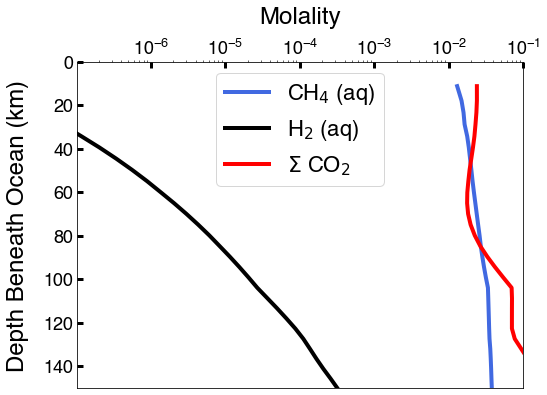

In [23]:
ib=65
ie=94


meth=specs_list["Methane(aq)"][ib:ie]
h2=specs_list["H2(aq)"][ib:ie]
sigC=(specs_list["CO2(aq)"][ib:ie]+specs_list["HCO3-"][ib:ie]+specs_list["CO3--"][ib:ie])
T_d = T[ib:ie]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(specs_list["Methane(aq)"][ib:ie],(depths[ib:ie]-depths[ie])/1000,linewidth=4, color='royalblue', label="CH$_4$ (aq)")
plt.plot(specs_list["H2(aq)"][ib:ie],(depths[ib:ie]-depths[ie])/1000,linewidth=4, color='black', label="H$_2$ (aq)")
plt.plot((specs_list["CO2(aq)"][ib:ie]+specs_list["HCO3-"][ib:ie]+specs_list["CO3--"][ib:ie]),(depths[ib:ie]-depths[ie])/1000, linewidth=4, color='red', label="$\Sigma$ CO$_2$")#+specs_list["HCO3-"][ib:ie]))#+specs_list["CO3--"][ib:ie])
plt.xscale("log")
plt.xlim([1.01e-7,1e-1])
plt.ylim([150,0])
plt.xlabel('Molality', fontsize=24, labelpad=14)
plt.ylabel('Depth Beneath Ocean (km)', fontsize=24, labelpad=14)
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(axis='both', labelsize=18, direction='in', length=6, width=3)  
plt.legend()
plt.savefig('Fig4b.pdf',bbox_inches='tight')

## Figure 4c

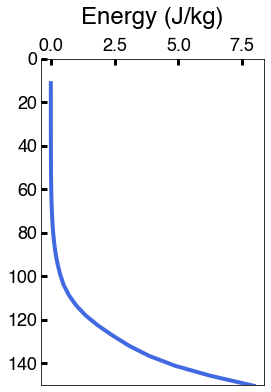

In [24]:
CO2E_S = sigC[-1]
CH4_S = meth[-1]
H2_S = h2[-1]


CO2E_D = sigC
CH4_D = meth
H2_D = h2


logK_S = np.log10(CH4_S/(H2_S**4*CO2E_S))

logK_D = np.log10(CH4_D/(H2_D**4*CO2E_D))


R = 8.314 # J/(K mol)
T = 273  # K


AE_2 = np.log(10)*R*T*(logK_S-logK_D)



EE_2 = AE_2*H2_D/4


ME_2 = 1e-13
Cells2=EE_2/ME_2
fig, ax = plt.subplots(figsize=(4,6))
ax.plot(EE_2,(depths[ib:ie]-depths[ie])/1000,linewidth=4, color='royalblue')
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(axis='both', labelsize=18, direction='in', length=6, width=3)   
plt.ylim([150,0])
plt.xlabel('Energy (J/kg)', fontsize=24, labelpad=14)
#plt.ylabel('Depth Beneath Ocean (km)', fontsize=24, labelpad=14)
plt.savefig('Fig4c.pdf',bbox_inches='tight')

## Figure 3a

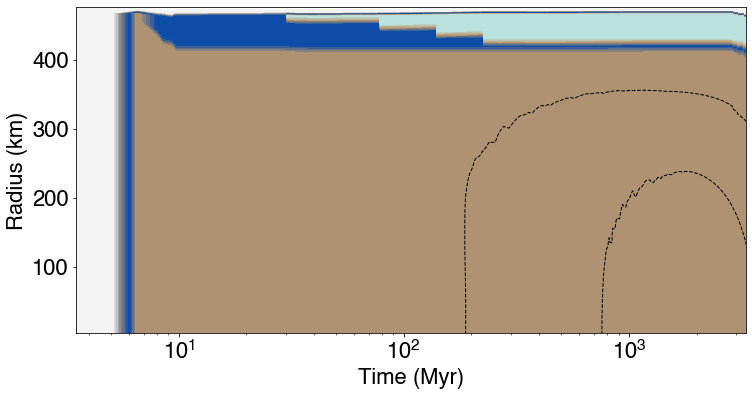

In [25]:
from plotHelper import *
from decay import *

def plotAttributeTest(self,att,tit):
    matplotlib.rcParams.update({'font.size': 22})
    data = np.zeros((self.nt,self.nr))
    for i in range(self.nr):
        for j in range(self.nt):
            data[j][i]=getattr(self.grid[j][i], att)
    f=plt.figure(figsize=(12,6))

    xi = np.zeros([self.nt, self.nr])
    yi = np.zeros([self.nt, self.nr])

    for i in range(0, self.nt):
        for j in range(0, self.nr):
            xi[i, j] = self.times[i] / Decay.YR / 10 ** 6
            yi[i, j] = self.grid[i, j].Top/1000
            
            
    temp = np.zeros((self.nt,self.nr))
    for i in range(self.nr):
        for j in range(self.nt):
            temp[j][i]=getattr(self.grid[j][i], "Temp")

    zi = np.transpose(data)
    zi2 = np.transpose(temp)
    xi = np.transpose(xi)
    yi = np.transpose(yi)

    CS3 = plt.contourf(xi,yi,zi, 20) #,vmin=vmin,vmax=vmax,cmap=JCmap) # Fix to use correct radii
    plt.contour( xi,yi,zi2, levels=[400,600,800], linewidths=1.0, colors='k', linestyles='dashed' )
    #plt.colorbar()
    plt.xlabel('Time (Myr)')
    plt.ylabel('Radius (km)')
    plt.title(tit)
    return f

# Define the colors and ranges
colors = ['white', 'grey', '#0047AB', '#C19A6B', '#b9e8ea']
# Create a colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
plt.rc('image', cmap=custom_cmap)
ax=plotAttributeTest(Ceres,"Celltype","")
plt.xscale("log")
plt.xlim([stime,etime])
plt.title("")

plt.savefig('Fig3a_red.pdf')

## Figure 3b

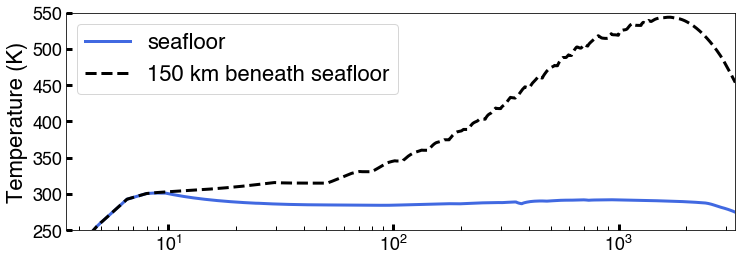

In [26]:
T_93 = np.zeros(Ceres.nt)
T_66 = np.zeros(Ceres.nt)

for i in range(0,Ceres.nt):
    T_93[i]=Ceres.grid[i,93].Temp
    T_66[i]=Ceres.grid[i,66].Temp

plt.figure(figsize=(12, 4))
plt.plot(Ceres.times/3.154e+7/1e6,T_93,'royalblue',label="seafloor",linewidth=3)
plt.plot(Ceres.times/3.154e+7/1e6,T_66,'k--',label="150 km beneath seafloor",linewidth=3)
plt.xscale("log")
plt.ylim([250,550])
plt.xlim([stime,etime])
plt.ylabel("Temperature (K)")
plt.legend()
plt.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
plt.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  
plt.savefig('Fig3b.pdf')

## Figure 3c

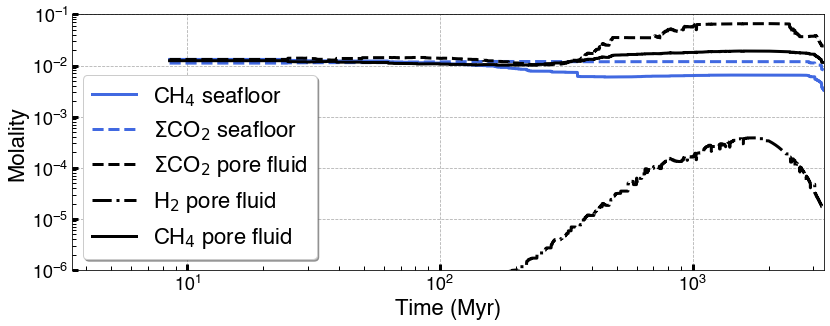

In [28]:
CO2_d= np.zeros(Ceres.nt)
CO3_d= np.zeros(Ceres.nt)
HCO3_d= np.zeros(Ceres.nt)
CH4_d= np.zeros(Ceres.nt)
H2_d= np.zeros(Ceres.nt)

for x in range(0,Ceres.nt):
    noEquilTime = 0
    timeS=x
    specs_list=dict()

    i=int(indTop1[timeS])
    for j in Ceres.grid[timeS,i].AqSpec:
        specs_list[j] = Ceres.grid[timeS,i].AqSpec[j]
                
    if "CO2(aq)" in specs_list:
        CO2_d[timeS]=specs_list["CO2(aq)"]
    if "CO3--" in specs_list:
        CO3_d[timeS]=specs_list["CO3--"]
    if "HCO3-" in specs_list:
        HCO3_d[timeS]=specs_list["HCO3-"]
    if "Methane(aq)" in specs_list:
        CH4_d[timeS]=specs_list["Methane(aq)"]
    if "H2(aq)" in specs_list:
        H2_d[timeS]=specs_list["H2(aq)"]
        

# interoplate over indices with errors. EQ3/6 failed to solve equilibration here.
H2_d[8100:9390]=np.linspace(H2_d[8100],H2_d[9390],9390-8100)
CH4_d[8100:9390]=np.linspace(CH4_d[8100],CH4_d[9390],9390-8100)
HCO3_d[8100:9390]=np.linspace(HCO3_d[8100],HCO3_d[9390],9390-8100)
CO2_d[8100:9390]=np.linspace(CO2_d[8100],CO2_d[9390],9390-8100)
CO3_d[8100:9390]=np.linspace(CO3_d[8100],CO3_d[9390],9390-8100)


plt.figure(figsize=(12, 5))

ind_good=CH4>1e-6
ind_good_d=CH4_d>1e-6

CO_d=CO3_d+HCO3_d+CO2_d
CO=CO3+HCO3+CO2

plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,CH4[ind_good]*0.5,'royalblue',label=r"CH$_4$ seafloor",linewidth=3)
plt.plot(Ceres.times[ind_good]/3.154e+7/1e6,CO[ind_good]*0.5,'royalblue',label=r"$\Sigma$CO$_2$ seafloor",linewidth=3,linestyle='--')
plt.plot(Ceres.times[ind_good_d]/3.154e+7/1e6,CO_d[ind_good_d]*0.5,'k',label=r"$\Sigma$CO$_2$ pore fluid",linewidth=3,linestyle='--')


plt.plot(Ceres.times[ind_good_d]/3.154e+7/1e6,H2_d[ind_good_d],'k',label=r"H$_2$ pore fluid",linewidth=3,linestyle='-.')
plt.plot(Ceres.times[ind_good_d]/3.154e+7/1e6,CH4_d[ind_good_d]*0.5,'k',label=r"CH$_4$ pore fluid",linewidth=3)
plt.ylim([1e-6,0.1])
plt.xlim([stime,etime])
plt.xlabel("Time (Myr)")
plt.ylabel("Molality")
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='lower left',
               ncol=1, fancybox=True, shadow=True)
plt.grid(True, linestyle='--')
plt.yticks([0.1, 0.01, 0.001,0.0001,0.00001,0.000001])

plt.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
plt.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  

plt.tight_layout()
plt.savefig('Fig3c.pdf')

## Figure 3d

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/673748249.py:22: RuntimeWarning: invalid value encountered in true_divide
  logK_e = np.log10(CH4_s_e/(H2_s_e**4*CO2E_s_e))
/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/673748249.py:24: RuntimeWarning: invalid value encountered in true_divide
  logK_e_d = np.log10(CH4_d_e/(H2_d_e**4*CO2E_d_e))


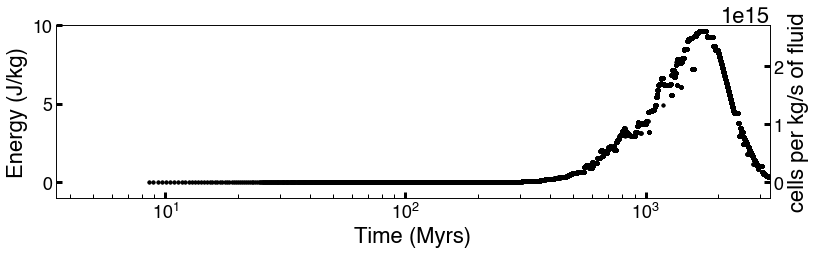

In [29]:
ind_good=np.logical_and(CH4>1e-6, CH4_d>1e-6)

CO2E_s_e = HCO3 + CO2 + CO3
CH4_s_e = CH4
H2_s_e = H2


CO2E_d_e = HCO3_d + CO2_d + CO3_d
CH4_d_e = CH4_d
H2_d_e = H2_d


CO2E_s_l = HCO3 + CO2 + CO3
CH4_s_l = CH4
H2_s_l = H2


CO2E_d_l = HCO3_d + CO2_d + CO3_d
CH4_d_l = CH4_d
H2_d_l = H2_d

logK_e = np.log10(CH4_s_e/(H2_s_e**4*CO2E_s_e))

logK_e_d = np.log10(CH4_d_e/(H2_d_e**4*CO2E_d_e))


R = 8.314 # J/(K mol)
T = 273  # K


AE = np.log(10)*R*T*(logK_e-logK_e_d)



EE = AE*H2_d_e/4


ME = 3.7e-15
Cells=EE/ME


fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax1.plot(Ceres.times[ind_good]/3.154e+7/1e6,EE[ind_good],'k.',linewidth=2)
ax2.plot(Ceres.times[ind_good]/3.154e+7/1e6,Cells[ind_good],'k.',linewidth=2)

ax1.set_xlabel('Time (Myrs)')
ax1.set_xscale('log')
plt.xlim([stime,etime])
ax1.set_ylabel('Energy (J/kg)', color='k')
ax2.set_ylabel('cells per kg/s of fluid', color='k')
ax2.set_ylim([-0.1*(10/3.7)*1e15,(10/3.7)*1e15])
ax1.set_ylim([-1,10])
ax1.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
ax1.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  
ax2.tick_params(axis='both', labelsize=18, direction='in', which='major', length=6, width=3) 
ax2.tick_params(axis='both', labelsize=18, direction='in', which='minor', length=4, width=1)  
plt.tight_layout()
plt.savefig('Fig3d.pdf')



## Figure S3

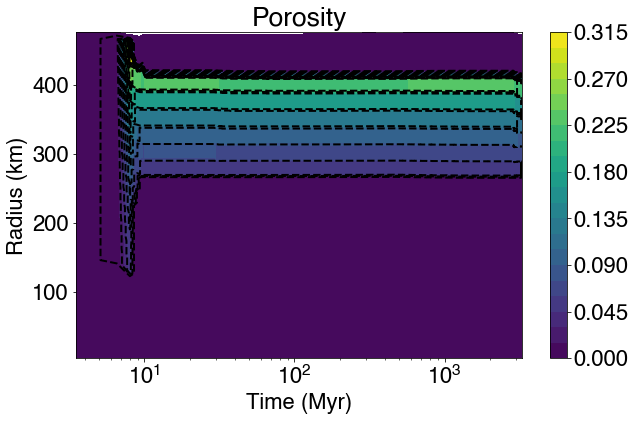

In [30]:
Ceres.plotAttribute("Porosity","Porosity")
plt.set_cmap('viridis')
plt.xscale("log")
plt.xlim([stime,etime])
plt.savefig('FigS3a.pdf') 

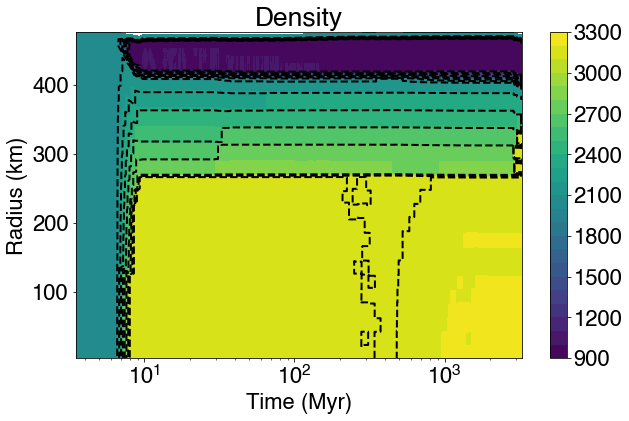

In [31]:
Ceres.plotAttribute("Dens","Density")
plt.xscale("log")
plt.xlim([stime,etime])
plt.savefig('FigS3b.pdf') 

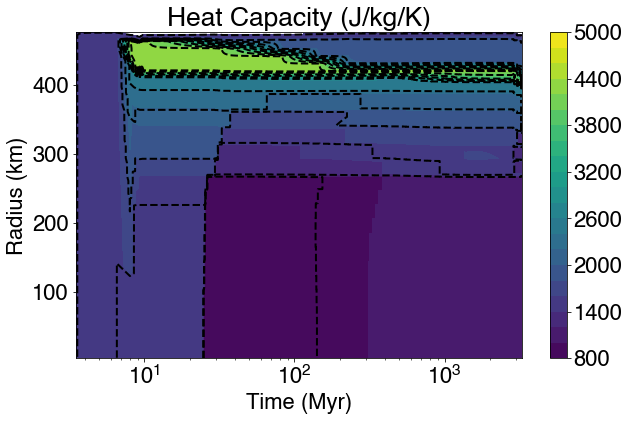

In [32]:
Ceres.plotAttribute("Cp","Heat Capacity (J/kg/K)")
plt.xscale("log")
plt.xlim([stime,etime])
plt.savefig('FigS3c.pdf') 

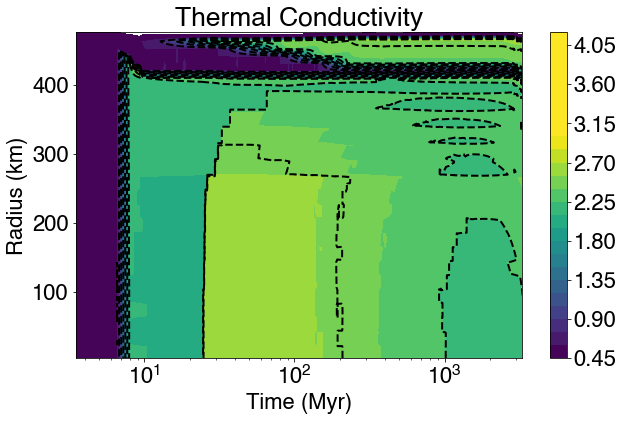

In [33]:
Ceres.plotAttribute("TCond","Thermal Conductivity")
plt.xscale("log")
plt.clim([0.5,3.0])
plt.xlim([stime,etime])
plt.savefig('FigS3d.pdf') 

## Figure S6

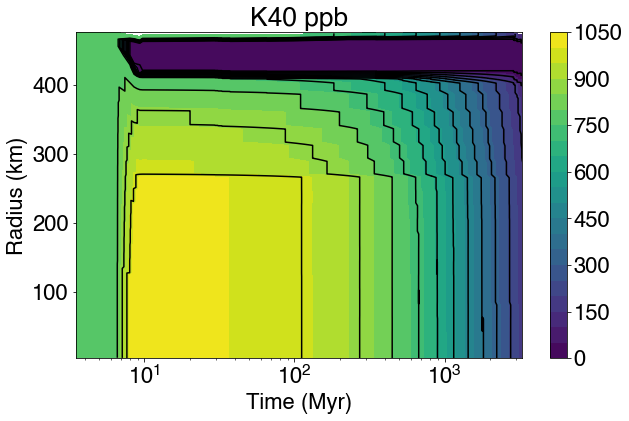

In [34]:
plt.rc('image', cmap="viridis")
Ceres.plotDictAttribute("RIComp","K40","K40 ppb",10**9)
plt.xscale("log")
plt.xlim([stime,etime])

plt.savefig('FigS6a.pdf')

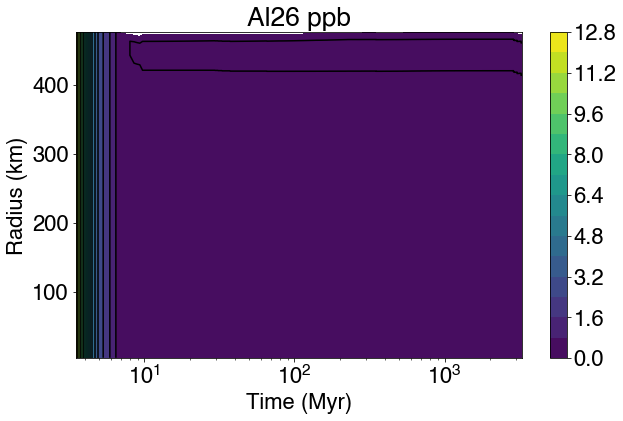

In [35]:
plt.rc('image', cmap="viridis")
Ceres.plotDictAttribute("RIComp","Al26","Al26 ppb",10**9)
plt.xscale("log")
plt.xlim([stime,etime])

plt.savefig('FigS6b.pdf')

## Figure S4

In [36]:
def TestMultiplotDictAttributeLine(model,att,keys,tit,radius,unit=1):
    plt.figure(figsize=(10, 6))
    for key in keys:
        data = np.zeros(model.nt)
        for j in range(model.nt):
            tempItem=getattr(model.grid[j][radius], att)
            if key in tempItem:
                data[j]=tempItem[key]
                
        x=model.times[data>1e-9]
        y=data[data>1e-9]
                
        plt.plot(x/3.154e+7/10**6,y,label=key)
    plt.xlabel('Time (Myr)')
    plt.ylabel(tit)
    plt.legend()

['Cl-' 'OH-' 'H2(aq)' 'SiO2(aq)' 'CO2(aq)' 'NH4+' 'Ca++' 'Na+' 'Fe++'
 'Mg++' 'MgCl+' 'FeCl+' 'NaCl(aq)' 'HCO3-' 'HS-' 'HSiO3-' 'NH3(aq)'
 'N2(aq)' 'MgHCO3+' 'CaHCO3+' 'CO3--' 'NaHSiO3(aq)' 'Formate' 'NaOH(aq)'
 'Methane(aq)' 'MgCO3(aq)' 'CaCO3(aq)' 'AlO2-' 'Na(For)(aq)' 'Urea(aq)'
 'Acetate' 'Acetamide(aq)' 'NH4CH3COO(aq)' 'NaCH3COO(aq)' 'Ethane(aq)']


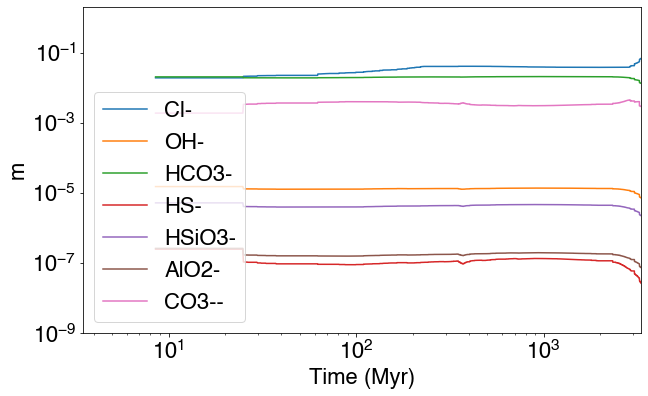

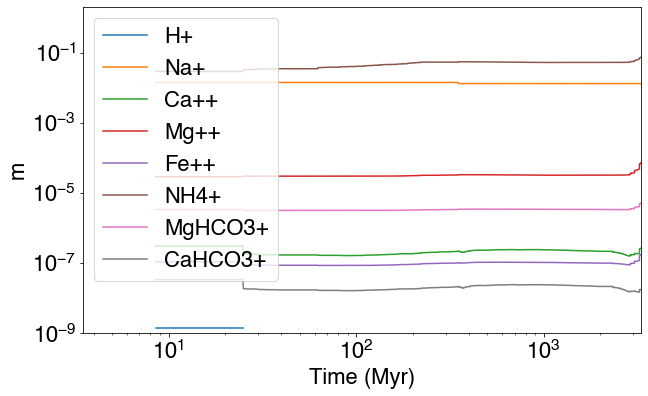

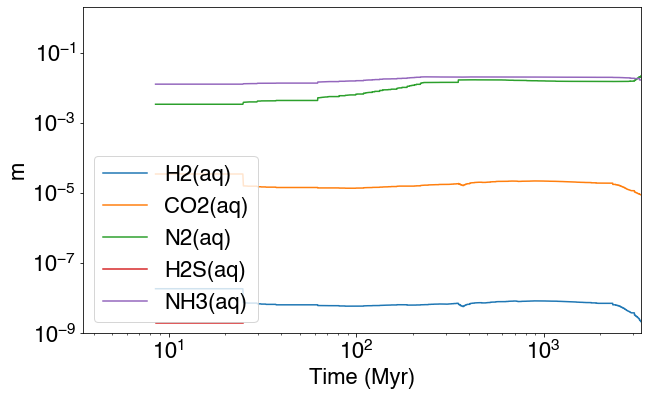

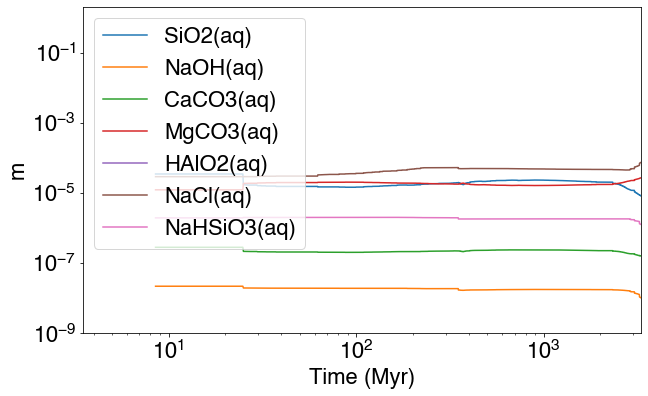

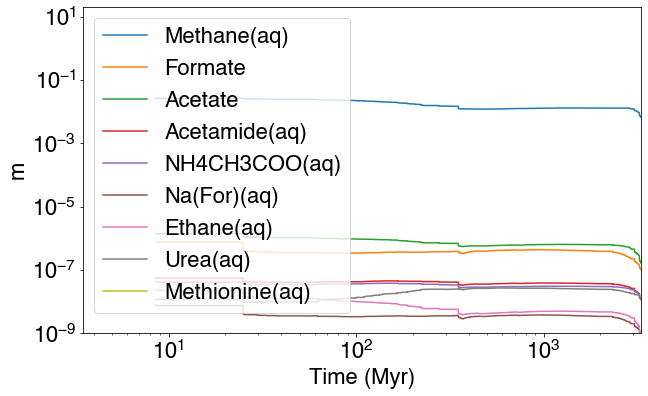

In [37]:
ind=93

names=np.array([])
for i in Ceres.grid[10000,ind].AqSpec:
    if Ceres.grid[10000,ind].AqSpec[i]>1e-9:
        names=np.append(names,[i])
        
print(names)
        
TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS4a.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS4b.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS4c.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"],"m",ind,1)
plt.ylim([10**-9,2])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS4d.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)","Methionine(aq)"],"m",ind,1)
plt.ylim([10**-9,20])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS4e.pdf')

#["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"]
#["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],
#["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"]
#["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"]
#["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)"]

## Figure S5

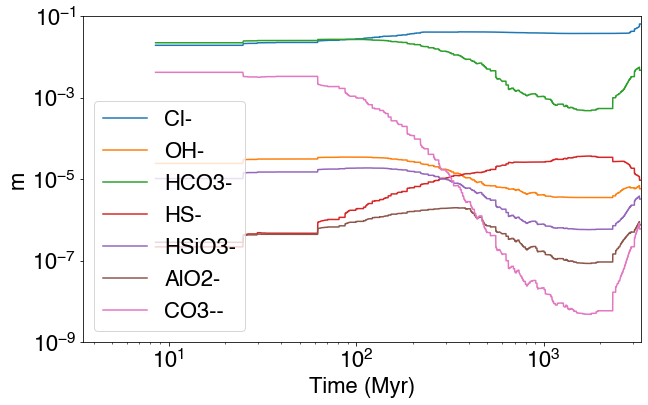

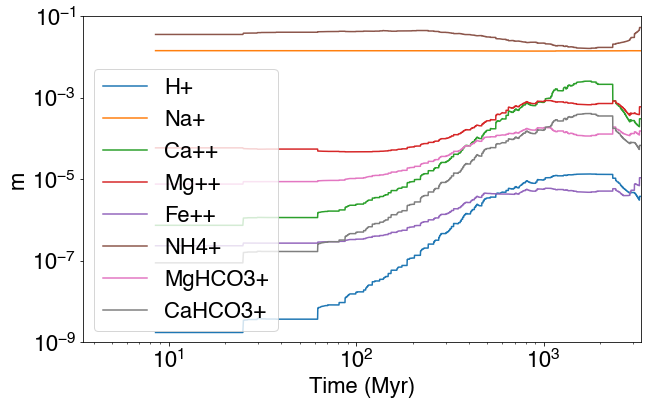

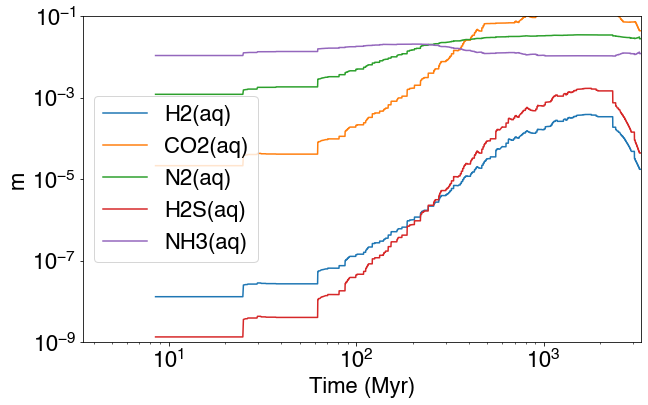

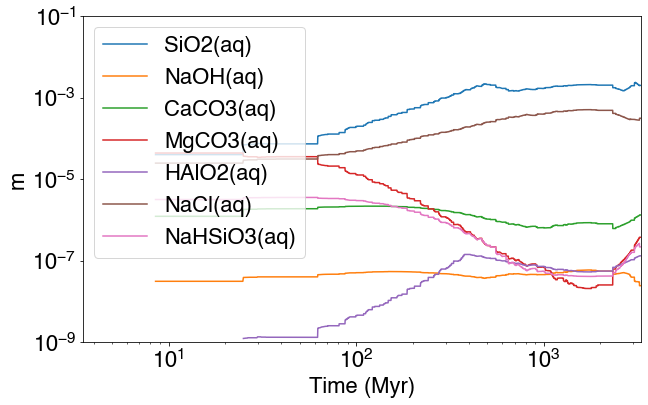

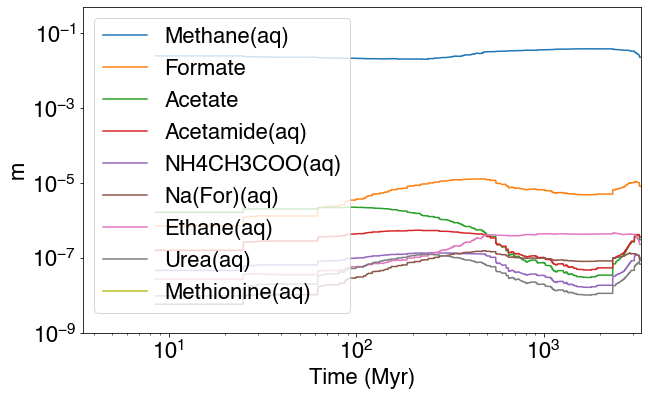

In [38]:
ind=65
        
TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS5a.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS5b.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS5c.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"],"m",ind,1)
plt.ylim([10**-9,0.1])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS5d.pdf')

TestMultiplotDictAttributeLine(Ceres,"AqSpec",["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)","Methionine(aq)"],"m",ind,1)
plt.ylim([10**-9,0.5])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')
plt.savefig('FigS5e.pdf')

#["Cl-","OH-","HCO3-","HS-","HSiO3-","AlO2-","CO3--"]
#["H2(aq)","CO2(aq)","N2(aq)","H2S(aq)","NH3(aq)"],
#["SiO2(aq)","NaOH(aq)","CaCO3(aq)","MgCO3(aq)","HAlO2(aq)","NaCl(aq)","NaHSiO3(aq)"]
#["H+","Na+","Ca++","Mg++","Fe++","NH4+","MgHCO3+","CaHCO3+"]
#["Methane(aq)","Formate","Acetate","Acetamide(aq)","NH4CH3COO(aq)","Na(For)(aq)","Ethane(aq)","Urea(aq)"]

['Magnetite' 'Pyrite' 'Diaspore' 'Siderite' 'Dolomite-ord' 'Talc'
 'Magnesite']


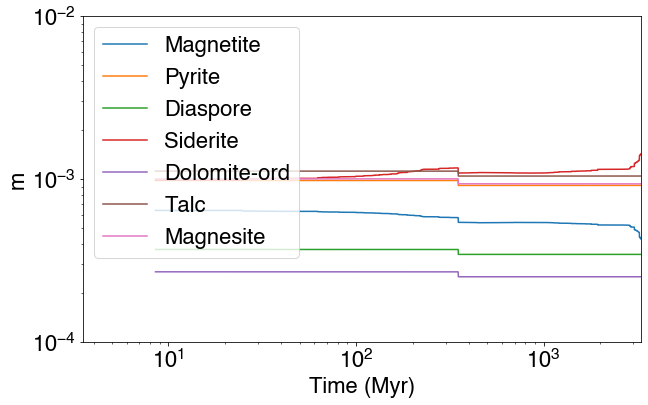

In [39]:
ind = 93

names=np.array([])
for i in Ceres.grid[500,ind].AqMin:
    if Ceres.grid[500,ind].AqMin[i]>1e-9:
        names=np.append(names,[i])
        
print(names)

TestMultiplotDictAttributeLine(Ceres,"AqMin",names,"m",ind,1)
plt.ylim([10**-4,0.01])
plt.xlim([stime,etime])
plt.yscale('log')
plt.xscale('log')

## Figure S2

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3462268766.py:116: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


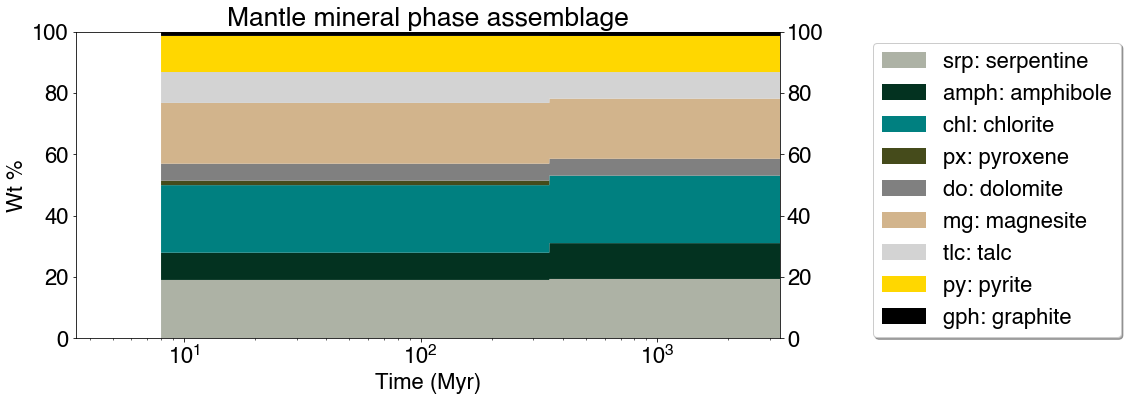

In [42]:
def plotPhaseAssemblageTest(self,radius,title, minorPhases="test"):
    pP=dict()

    if minorPhases=="test":
        minorPhases= ['F','Mica', 'Fsp', 'Sp', 'ky', 'Gt', 'trd', 'crst','Stlp','law','Pu','ank','Mica','Bio','Fsp','Sp']

    col_dict={"IOM":"#964B00",
              "IOM pyrolysates":"#5C4033",
              "minor phases":'skyblue',
              "gph: graphite":"#000000",
              "qtz: quartz":"#FFFFFF",
              "cc: calcite":"#964B00",
              "mg: magnesite":"#d2b48c",
              "do: dolomite":"#808080",
              "px: pyroxene":"#454B1B",
              "py: pyrite":"#FFD700",
              "po: pyrrhotite":"#E1C16E",
              "amph: amphibole":"#033220",
              "chl: chlorite":"#008080",
              "tlc: talc":"#D3D3D3",
              "pl: plagioclase":"#FF0000",
              "hem: hematite":"#b7410e",
              "gth: goethite":"#A9A9A9",
              "mag: magnetite":"#5C4033",
              "sp: spinel":"#E6E6FA",
              "srp: serpentine":"#adb2a5",
              "su: sulfates":"#b0c4de",
              "phl: phlogopite":"#d53600",
              "tro: troilite":"#C0C0C0",
              "ol: olivine":"#9ab973",
              "ens: enstatite":"#CC7722",
              "cor: corundum":"#e0115f",
              "gt: garnet":"#9A2A2A",
              "pu: pu: pumpellyite":"skyblue",
              "Iron":"#A9A9A9"}

    lab_dict={"IOM":"IOM",
              "IOMp":"IOM pyrolysates",
              "other":"minor phases",
              "gph":"gph: graphite",
              "q":"qtz: quartz",
              "Opx":"px: pyroxene",
              "Cpx":"px: pyroxene",
              "acm":"px: pyroxene",
              "pyr":"py: pyrite",
              "Po":"po: pyrrhotite",
              "tro":"tro: troilite",
              "lot":"tro: troilite",
              "trov":"po: pyrrhotite",
              "Amph":"amph: amphibole",
              "Chl":"chl: chlorite",
              "Tlc":"tlc: talc",
              "Do":"do: dolomite",
              "Cc":"cc: calcite",
              "cc": "cc: calcite",
              "dol":"do: dolomite",
              "arag":"cb: carbonates",
              "Pl":"pl: plagioclase",
              "ab":"pl: plagioclase",
              "hem":"hem: hematite",
              "gth": "gth: goethite",
              "Ol":"ol: olivine",
              "Sp":"mag: magnetite",
              "Atg":"srp: serpentine",
              "glt":"srp: serpentine",
              "cen":"ens: enstatite",
              "pren": "ens: enstatite",
              "en": "ens: enstatite",
              "liz": "srp: serpentine",
              "any":"su: sulfates",
              "naph":"phl: phlogopite",
              "cor":"cor: corundum",
              "Mag":"mg: magnesite",#"mag: magnetite",
              "Gt":"gt: garnet",
              "Pu":"pu: pumpellyite",
              "iron":"Iron"}


    for j in range(self.nt):
        phases=self.grid[j][radius].RockPhases
        for i in range(len(phases)):
            if "_rs" in phases[i]:
                phases[i]=phases[i].replace('_rs','')
            if "_1" in phases[i]:
                phases[i]=phases[i].replace('_1','')
        for i in range(0,len(phases)):
            if not phases[i]=="Bulk":
                labT="other"
                if phases[i] not in minorPhases and phases[i] not in lab_dict:
                    print(phases[i])
                if phases[i] in lab_dict:
                    labT=lab_dict[phases[i]]
                if labT in pP:
                    pP[labT][j]+=self.grid[j][radius].RockPhaseDat[i]["wt%"]
                else:
                    pP[labT]=np.zeros(self.nt)
                    pP[labT][j]=self.grid[j][radius].RockPhaseDat[i]["wt%"]
        if "IOM" in self.grid[j][radius].RockComp and self.grid[j][radius].RockComp["IOM"]>0:
            if "IOM" in pP: 
                pP["IOM"][j]+=self.grid[j][radius].RockComp["IOM"]/self.grid[j][radius].Mass*100
            else:
                pP["IOM"]=np.zeros(self.nt)
                pP["IOM"][j]=self.grid[j][radius].RockComp["IOM"]/self.grid[j][radius].Mass*100
    sumM=np.zeros(self.nt)
    for j in range(self.nt):
        for i in pP:
            if not i=="IOM":
                sumM[j]+=pP[i][j]
    for j in range(self.nt):
        if "IOM" in pP:
            IOMp=pP["IOM"][j]
        else:
            IOMp=0
        for i in pP:
            if not i=="IOM":
                pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


    #x_values = list(pP.keys())
    #y_values_list = list(pP.values())

    #print(pP.values())
    #print(pP.keys())



    color_map=[]
    for i in pP:
        if i in col_dict:
            color_map.append(col_dict[i])
        else:
            color_map.append(col_dict['minor phases'])


    f=plt.figure(figsize=(12,6))
    plt.stackplot(self.times/Decay.YR/10**6,pP.values(),labels=pP.keys(),colors = color_map) 
    #plt.stackplot(x_values, y_values_list, labels=list(pP.keys()))
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    #if LogScale==1:
    #    plt.xscale("log")
    plt.xlabel('Time (Myr)')
    plt.ylabel('Wt %')
    plt.title(title)
    #plt.title('Phase assemblage at %0.2f kms deep'%(self.radii[-1]-self.radii[radius]))
    plt.tick_params(labelright=True, right=True)
    plt.ylim([0,100])
    plt.xlim([stime,etime])
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.5, 1.0), loc='upper right',
               ncol=1, fancybox=True, shadow=True)
    #plt.show()
    return f

plotPhaseAssemblageTest(Ceres,93, "Mantle mineral phase assemblage",minorPhases="test")
plt.xscale("log")
plt.savefig('FigS2a.pdf',bbox_inches='tight')

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3462268766.py:116: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


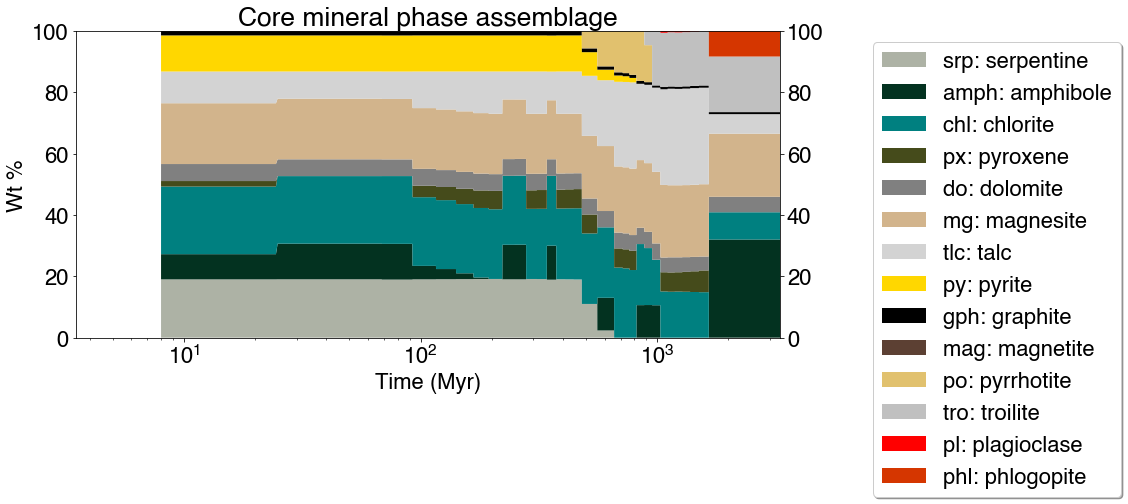

In [43]:
plotPhaseAssemblageTest(Ceres,0, "Core mineral phase assemblage",minorPhases="test")
plt.xscale("log")
plt.savefig('FigS2b.pdf',bbox_inches='tight')

## Ice shell rayleigh number plot

In [44]:
def findBottomIce(Ceres,it):
    check=0
    for i in range(nr-1,0,-1):
        if check==0:
            if Ceres.grid[it,i].Celltype==4:
                check=1
        if check==1:
            if Ceres.grid[it,i].Celltype!=4:
                check=0
                return i
    return 98

nZ = 24
Z  = np.linspace(0.01,1,nZ)    # fraction
Ra=np.zeros([nZ,Ceres.nt])
ls=np.zeros(Ceres.nt)
Tb=np.zeros(Ceres.nt)
bIs=np.zeros(Ceres.nt)

for i in range(0,Ceres.nt):
    for j in range(0,nZ):
        bI = findBottomIce(Ceres,i)+1
        bIs[i]=bI
        ltot = Ceres.grid[i,-1].Top-Ceres.grid[i,bI].Bot  # m
        ls[i]= ltot
        l    = ltot*Z[j]
        Tb[i]=Ceres.grid[i,bI].Temp
        
        Ttop= (Ceres.grid[i,bI].Temp*Z[j]+Ceres.grid[i,-1].Temp*(1-Z[j]))
        T   = (Ceres.grid[i,bI].Temp+Ttop)/2 # 
        dT  = Ceres.grid[i,bI].Temp-Ttop #Ceres.grid[i,-1].Temp  # 

        
        Tm   = 273    # K
        Beta = 1.5e-4 # 5.5e-5 # K-1
        rho  = 917  # ice kg m-3
        g    = 0.27   # m s-2
        nu0  = 5e13 #1e12   # Pa s
        R    = 8.314  # J K−1 mol−1
        E    = 50000  # J mol -1
        Cp   = (0.5057-0.001863 * (T-273)) * 4.184 *1000 # J/kg/K
        k    = (0.0053*(1+0.0015*(T-273))) * 4.184 *100  # J/m/s/K

        nu   = nu0 * np.exp(E/(R*Tm)*(Tm/T-1))
        alpha= k/(rho*Cp)
        dRho = rho*Beta*dT

        RaTop = l**2/alpha
        RaBot = nu/(dRho*l*g)

        Ra[j,i]=RaTop/RaBot




/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/4200298148.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  RaBot = nu/(dRho*l*g)


/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3843845300.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(Ceres.times/3.154e+7/1e6,Z,np.log10(Ra),25)
/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_40160/3843845300.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.contour(Ceres.times/3.154e+7/1e6,Z,np.log10(Ra),[3])


Text(0, 0.5, 'fraction of ice-shell')

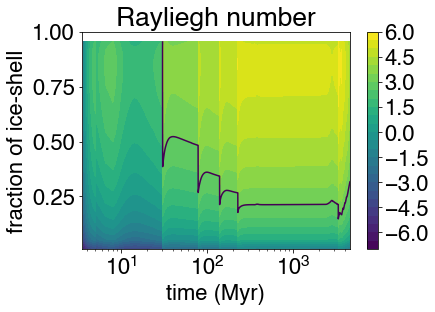

In [45]:
plt.contourf(Ceres.times/3.154e+7/1e6,Z,np.log10(Ra),25)
plt.colorbar()
plt.contour(Ceres.times/3.154e+7/1e6,Z,np.log10(Ra),[3])
plt.xscale('log')
plt.title('Rayliegh number')
plt.xlabel('time (Myr)')
plt.ylabel('fraction of ice-shell')

## Energy from fluid mixing

547.4579813505735
290.74995050058766
0.00032454
7.8127e-09


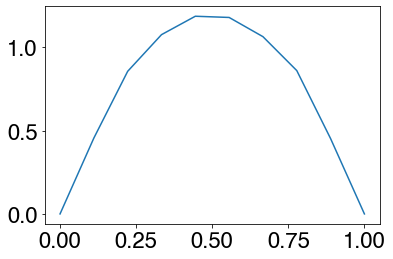

In [46]:
i1=0
i2=28
print(T_d[i1])
print(T_d[i2])
print(H2_D[i1])
print(H2_D[i2])

nMix=10
mix_ratio=np.linspace(0,1,nMix)

CH4mix=mix_ratio*CH4_D[i1]+(1-mix_ratio)*CH4_D[i2]
CO2mix=mix_ratio*CO2E_D[i1]+(1-mix_ratio)*CO2E_D[i2]
H2mix =mix_ratio*H2_D[i1]+(1-mix_ratio)*H2_D[i2]
Tmix  =mix_ratio*T_d[i1]+(1-mix_ratio)*T_d[i2]
Kmix = np.log10(CH4mix/(H2mix**4*CO2mix))


fInd = np.zeros(nMix)
K_Tmix = np.zeros(nMix)
for i in range(0,nMix):
    fInd[i] = np.argmin(np.abs(T_d-Tmix[i]))
    #print(fInd)
    K_Tmix[i] = logK_D[int(fInd[i])]
    


AE_mix = np.log(10)*R*T*(K_Tmix-Kmix)



EE_mix = AE_mix*H2mix/4 


#plt.plot(mix_ratio,Tmix)
#plt.plot(mix_ratio,H2mix)
plt.plot(mix_ratio,EE_mix)



## Potential energy and temperature change from differentiation

In [48]:
G = 6.67*10**-11
M = 9.38*10**20 #kg
R = 490*1000 #km
U=-3/5 * G * M**2 / R

Cp = 2000 #J/kg/K

# Ceres
# Mean diameter: 939.4 km
# Mass: 9.3839e20
R_C = 939.4e3 / 2;
M_C = 9.3839e20;
C_p = 2e3;
G = 6.67e-11;
rho_ice = 1e3;
rho_C = M_C / (4/3 * np.pi * R_C**3);



E_G_C = 3/5 * G * M_C**2 / R_C;
T_G_C = E_G_C / (M_C * C_p);

print(T_G_C)
print(E_G_C)


R_ice = R_C - 100e3;

M_ice = 4/3 * np.pi * (R_C**3 - R_ice**3) * rho_ice;
M_rock = M_C - M_ice;
rho_rock = M_rock / (4/3 * np.pi * R_ice**3);

E_G_rock = 3/5 * G * M_rock**2 / R_ice;

print(E_G_rock)

E_G_ice = (3/5 * G * M_ice**2 / (R_C**3 - R_ice**3)**2) * (R_C**5 - R_ice**5 - 2.5 * R_ice**3 * (R_C**2 - R_ice**2));
E_G_ice = (1/2 * G * M_ice**2 / (R_C))

print(E_G_ice)

Delta_E_G = -(E_G_rock + E_G_ice) + E_G_C;
Delta_T_G = Delta_E_G / (M_C * C_p);

print(Delta_T_G)

39.97697232275921
7.502798211590804e+25
5.54932077476811e+25
3.5119665687915727e+24
8.537392661598782


## Moment of inertia

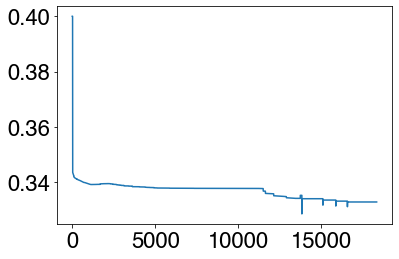

In [49]:
def MOI_shell(R,T,p):
    return 8/15*np.pi*p*((R+T)**5-R**5)

def MOI_thin_shell(R,T,p):
    M = 4*np.pi*p*R**2*T
    return 2/3*M*R**2


T=np.zeros(Ceres.nr)
Th=np.zeros(Ceres.nr)
#por=np.zeros(Ceres.nr)
bots=np.zeros(Ceres.nr)
dens=np.zeros(Ceres.nr)
MOI=np.zeros(Ceres.nr)
masses=np.zeros(Ceres.nr)

MOI_norm=np.zeros(Ceres.nt)
mass_sum=np.zeros(Ceres.nt)


for k in range(0,Ceres.nt):
    timeS=k
    for i in range(0,Ceres.nr):
        T[i]=Ceres.grid[timeS,i].Temp
        #por[i]=Ceres.grid[timeS,i].Porosity
        bots[i]=Ceres.grid[timeS,i].Bot
        Th[i] = Ceres.grid[timeS,i].Top-bots[i]
        dens[i]=Ceres.grid[timeS,i].Dens
        masses[i]=Ceres.grid[timeS,i].Mass
        MOI[i]=MOI_shell(bots[i],Th[i],dens[i])
        
    mass_sum[k]=np.sum(masses)
    MOI_norm[k]=np.sum(MOI)/(mass_sum[k]*Ceres.grid[timeS,Ceres.nr-1].Top**2)
        
plt.plot(MOI_norm)
    